In [1]:
import GaitLab2Go as GL2GO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

2022-08-13 22:52:34.905238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 22:52:34.905256: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# def sw_split(Participant,subject_wise,split=0.10,seed=42):
#     np.random.seed(seed)
#     if subject_wise:
#         UniqParti=np.unique(Participant)
#         num=np.round(UniqParti.shape[0]*split).astype('int64')
#         np.random.shuffle(UniqParti)
#         extract=UniqParti[0:num]
#         test_index=np.array([],dtype='int64')
#         for j in extract:
#             test_index=np.append(test_index,np.where(Participant==j)[0])
#         train_index=np.delete(np.arange(len(Participant)),test_index)
#         np.random.shuffle(test_index)
#         np.random.shuffle(train_index)

#     else:
#         I=np.arange(len(Participant)).astype('int64')
#         np.random.shuffle(I)
#         num=np.round(Participant.shape[0]*split).astype('int64')
#         test_index=I[0:num]
#         train_index=I[num:]
#         extract=np.unique(Participant[test_index])
#     return train_index,test_index,extract
                

In [3]:
def subject_wise_split(x, y, participant, subject_wise=True, split=0.10, seed=42):
    np.random.seed(seed)
    if subject_wise:
        uniq_parti = np.unique(participant)
        num = np.round(uniq_parti.shape[0]*split).astype('int64')
        np.random.shuffle(uniq_parti)
        extract = uniq_parti[0:num]
        test_index = np.array([], dtype='int64')
        for j in extract:
            test_index = np.append(test_index, np.where(participant == j)[0])
        train_index = np.delete(np.arange(len(participant)), test_index)
        np.random.shuffle(test_index)
        np.random.shuffle(train_index)

    else:
        index = np.arange(len(participant)).astype('int64')
        np.random.shuffle(index)
        num = np.round(participant.shape[0] * split).astype('int64')
        test_index = index[0:num]
        train_index = index[num:]

    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]
    subject_test = participant[test_index]
    subject_train = participant[train_index]

    return x_train, y_train, x_test, y_test, subject_train, subject_test

In [4]:
def lda_featuers(x_train,y_train):
    n_components=np.unique(y_train).shape[0]-1
    lda= LDA(n_components=n_components)
    x_train=lda.fit_transform(x_train,y_train)
    return x_train,lda

In [5]:
dp=pd.read_pickle('../dataset/cycle1_with_wrist_Normalized.pkl') #cycle1_with_wrist,cycle1_9surface

In [6]:
Ndata=dp.Ndata

In [7]:
Ndata['Surface']

array([array(['BnkL'], dtype='<U4'), array(['BnkL'], dtype='<U4'),
       array(['BnkL'], dtype='<U4'), ..., array(['StrU'], dtype='<U4'),
       array(['StrU'], dtype='<U4'), array(['StrU'], dtype='<U4')],
      dtype=object)

In [8]:
for i in range(Ndata['Surface'].shape[0]):
    Ndata['Surface'][i]=Ndata['Surface'][i][0]
    Ndata['Subjects'][i]=Ndata['Subjects'][i][0]

In [9]:
#delete_col=np.unique(np.where(Ndata['wrist_Acc_X']==np.array([999]))[0]) #for wrist sensors
#for i in Ndata.keys():
    #Ndata[i]=np.delete(np.array(Ndata[i]),delete_col,axis=0)

In [10]:
output_parameters=['trunk_Acc','trunk_Gyr','trunk_Mag',
                   'shankR_Acc','shankR_Gyr','shankR_Mag',
                   'shankL_Acc','shankL_Gyr','shankL_Mag',
                   'thighR_Acc','thighR_Gyr','thighR_Mag',
                   'thighL_Acc','thighL_Gyr','thighL_Mag']
parameters=list(Ndata.keys())
for i in output_parameters:
    print(f'extracting_{i}_Magnitude')
    idx=np.array(parameters)[np.where(np.char.find(parameters,i)!=-1)[0].astype('int64')]
    Ndata[f'{i}_Val']=np.sqrt(np.array(Ndata[idx[0]])**2+ np.array(Ndata[idx[1]])**2+np.array(Ndata[idx[2]])**2)

extracting_trunk_Acc_Magnitude
extracting_trunk_Gyr_Magnitude
extracting_trunk_Mag_Magnitude
extracting_shankR_Acc_Magnitude
extracting_shankR_Gyr_Magnitude
extracting_shankR_Mag_Magnitude
extracting_shankL_Acc_Magnitude
extracting_shankL_Gyr_Magnitude
extracting_shankL_Mag_Magnitude
extracting_thighR_Acc_Magnitude
extracting_thighR_Gyr_Magnitude
extracting_thighR_Mag_Magnitude
extracting_thighL_Acc_Magnitude
extracting_thighL_Gyr_Magnitude
extracting_thighL_Mag_Magnitude


In [11]:
Surface=Ndata['Surface']
Participant=Ndata['Subjects']
split=0.3
# sub=[False,True]
Lab=GL2GO.data_processing()
# seed=[5,10,15,20,25,30,42]
del Ndata['Surface']
del Ndata['Subjects']

In [12]:
labels = np.load('../dataset/labels.npy', allow_pickle=True)

In [13]:
Participant = [int(num.strip('subject_')) for num in Participant]

In [14]:
np.array(Participant)

array([ 1,  1,  1, ..., 30, 30, 30])

In [15]:
np.array(Ndata['shankR_Gyr_X']).shape

(18687, 101)

In [16]:
# result={}
# for rseed in [23,54]:
#     result[f'Rseed_{rseed}']={}
#     for condi in range(len([True, False])):
#         if condi:
#             print('Splitting Subject wise')
#         else:
#             print('Splitting Random')
            
#         train_index,test_index,extract=sw_split(np.array(Participant),split=split,subject_wise=condi,seed=rseed)
#         train_index,test_index=train_index.astype('int64'),test_index.astype('int64')
#        # for r in range(0,len(delete_col)):
#         #    tr=np.where(test_index==delete_col[r])[0]
#          #   wrist_test_index=np.delete(test_index,tr)
#         #for r in range(0,len(delete_col)):
#          #   tr=np.where(train_index==delete_col[r])[0]
#           #  wrist_train_index=np.delete(train_index,tr)
        
        
#         AnnData={'X_train':{},'X_test':{},'y_train':{},'y_test':{}}
#         lda={}
#         Acuracy={}
#         Uncm={}
#         Ncm={}
#         train_acurracy={}
#         num_featuers={}
#         F1score={}
#         Precision_score={}
#         Recall_score={}
#         F1score_classes={}
        
#         for i in Ndata.keys():
#             print(f'extracting 8 features from {i}')
#             x_train,lda[f'{i}']=lda_featuers(np.array(Ndata[i])[train_index],Surface[train_index])
#             AnnData['X_train'][f'{i}']=x_train
#             AnnData['X_test'][f'{i}']=lda[f'{i}'].transform(np.array(Ndata[i])[test_index])
#             AnnData['y_train'][f'{i}']=Surface[train_index]
#             AnnData['y_test'][f'{i}']=Surface[test_index]
#         output_parameters=['trunk_Acc','trunk_Gyr','trunk_Mag',
#                            'shankR_Acc','shankR_Gyr','shankR_Mag',
#                            'shankL_Acc','shankL_Gyr','shankL_Mag',
#                            'thighR_Acc','thighR_Gyr','thighR_Mag',
#                            'thighL_Acc','thighL_Gyr','thighL_Mag']
#         parameters=list(AnnData['X_train'].keys())
#         for i in output_parameters:
#             print(f'concatenating X,Y and Z features of {i} to extract 8 new features')
#             idx=np.array(parameters)[np.where(np.char.find(parameters,i)!=-1)[0].astype('int64')]
#             x_train=np.concatenate([AnnData['X_train'][idx[0]],
#                                     AnnData['X_train'][idx[1]],
#                                     AnnData['X_train'][idx[2]]],axis=-1)
#             x_test=np.concatenate([AnnData['X_test'][idx[0]],
#                                    AnnData['X_test'][idx[1]],
#                                    AnnData['X_test'][idx[2]]],axis=-1)
#             #x_train,lda[f'{i}']=lda_featuers(x_train,Surface[train_index])
#             AnnData['X_train'][f'{i}']=x_train
#             AnnData['X_test'][f'{i}']=x_test
#             AnnData['y_train'][f'{i}']=Surface[train_index]
#             AnnData['y_test'][f'{i}']=Surface[test_index]
#             del AnnData['X_train'][idx[0]]
#             del AnnData['X_train'][idx[1]]
#             del AnnData['X_train'][idx[2]]
#             del AnnData['X_test'][idx[0]]
#             del AnnData['X_test'][idx[1]]
#             del AnnData['X_test'][idx[2]]
#         parameters=list(AnnData['X_train'].keys())
#         output_parameters=['trunk','thighR','shankR','thighL','shankL']
#         for i in output_parameters:
#             print(f'concatenating all the features {i}')
#             idx=np.array(parameters)[np.where(np.char.find(parameters,i)!=-1)[0].astype('int64')]
#             x_train=np.concatenate([AnnData['X_train'][idx[0]],
#                                     AnnData['X_train'][idx[1]],
#                                     AnnData['X_train'][idx[2]],
#                                     AnnData['X_train'][idx[3]],
#                                     AnnData['X_train'][idx[4]],
#                                     AnnData['X_train'][idx[5]]],axis=-1)
#             x_test=np.concatenate([AnnData['X_test'][idx[0]],
#                                    AnnData['X_test'][idx[1]],
#                                    AnnData['X_test'][idx[2]],
#                                    AnnData['X_test'][idx[3]],
#                                    AnnData['X_test'][idx[4]],
#                                    AnnData['X_test'][idx[5]]],axis=-1)
#             AnnData['X_train'][f'{i}']=x_train
#             AnnData['X_test'][f'{i}']=x_test
#             AnnData['y_train'][f'{i}']=Surface[train_index]
#             AnnData['y_test'][f'{i}']=Surface[test_index]  


#         AnnData['X_train']['Right']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighR'],
#                                                     AnnData['X_train']['shankR']],axis=-1)
#         AnnData['X_train']['Left']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighL'],
#                                                     AnnData['X_train']['shankL']],axis=-1)
#         AnnData['X_train']['Lower']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighR'],
#                                                     AnnData['X_train']['shankR'],AnnData['X_train']['thighL'],
#                                                     AnnData['X_train']['shankL']],axis=-1)
        
#         AnnData['X_test']['Right']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighR'],
#                                                     AnnData['X_test']['shankR']],axis=-1)
#         AnnData['X_test']['Left']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighL'],
#                                                     AnnData['X_test']['shankL']],axis=-1)
#         AnnData['X_test']['Lower']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighR'],
#                                                     AnnData['X_test']['shankR'],AnnData['X_test']['thighL'],
#                                                     AnnData['X_test']['shankL']],axis=-1)
        
#         AnnData['y_train']['Right']=Surface[train_index]
#         AnnData['y_train']['Left']=Surface[train_index]
#         AnnData['y_train']['Lower']=Surface[train_index]
#         AnnData['y_test']['Right']=Surface[test_index]
#         AnnData['y_test']['Left']=Surface[test_index]
#         AnnData['y_test']['Lower']=Surface[test_index]
# #         models=['trunk','thighR','shankR','thighL','shankL','Right','Left','Lower']
#         models=['Lower']
#         for KEY in models:
#             X_train=AnnData['X_train'][KEY]
#             X_test=AnnData['X_test'][KEY]
#             y_train=Lab.one_hot(AnnData['y_train'][KEY])
#             y_test=AnnData['y_test'][KEY]
#             hid_layers=(606,303,606) #hidden layers
#             model='classification' #problem type
#             output= y_train.shape[-1] #ouput shape 
#             input_shape=X_train.shape[-1]
#             ann=Lab.ANN(hid_layers=hid_layers,model=model,output=output,input_shape=input_shape,activation_hid='relu') # relu in hidden layers
#             print('OG fitting shapes')
#             print(X_train.shape)
#             print(y_train.shape)
#             ann.fit(X_train,y_train,batch_size=512,epochs=50, validation_split=0.1)
#             y_pred=ann.predict(X_test)
#             num_featuers[f'{KEY}']=X_test.shape[1]
#             a=y_pred.argmax(axis=1)
#             b=np.zeros(a.shape[0]).astype('str')
#             for i in range(Lab.surface_name.shape[0]):
#                 b[np.where(a==i)[0]]=Lab.surface_name[i]
#             print(KEY,np.mean(y_test==b))
#             y_pred=b
#             Acuracy[f'{KEY}']=accuracy_score(y_test, y_pred)
#             Con=confusion_matrix(y_test,b)
#             Uncm[f'{KEY}']=Con
#             da=confusion_matrix(y_test, y_pred, normalize='true')
#             cm=pd.DataFrame(da,columns=Lab.surface_name,index=Lab.surface_name)
#             Ncm[f'{KEY}']=cm
#             b=ann.predict(X_train)
#             a=b.argmax(axis=1)
#             train_acurracy[f'{KEY}']=np.mean(y_train.argmax(axis=1)==a)
#             F1score[f'{KEY}']=f1_score(y_test, y_pred,average='weighted')
#             F1score_classes[f'{KEY}']=f1_score(y_test, y_pred,average=None)
#             print(F1score_classes)
#             Precision_score[f'{KEY}']=precision_score(y_test, y_pred,average='weighted')
#             Recall_score[f'{KEY}']=recall_score(y_test, y_pred,average='weighted')
            
            
#         result[f'Rseed_{rseed}'][f'subject_wise_{condi}']={'Acuracy':Acuracy,'F1score':F1score,
#                                                                 'precision_score':Precision_score,
#                                                                 'recall_score':Recall_score,'Ncm':Ncm,
#                                                                 'Uncm':Uncm,'num_featuers':num_featuers,
#                                                                 'train_acurracy':train_acurracy,'Data':AnnData,
#                                                                 'lda':lda,'Subject_test':extract,'F1score_classes':F1score_classes}

In [17]:
# !mkdir LDA9Surface
# pd.to_pickle(result,'.\\LDA9Surface\\Magnitude_sepratedLDA_15%_32_606n.pkl')

In [18]:
def single_run(seed, subject_wise):
    rseed = seed
    condi = subject_wise
    
    result={}
    result[rseed]={}
    if condi:
        print('Splitting Subject wise')
    else:
        print('Splitting Random')

#     train_index,test_index,extract=subject_wise_split(np.array(Participant),split=split,subject_wise=condi,seed=rseed)
#     train_index,test_index=train_index.astype('int64'),test_index.astype('int64')

    AnnData={'X_train':{},'X_test':{},'y_train':{},'y_test':{}}
    lda={}
    Acuracy={}
    Uncm={}
    Ncm={}
    train_acurracy={}
    num_featuers={}
    F1score={}
    Precision_score={}
    Recall_score={}
    F1score_classes={}

    for i in Ndata.keys():
        print(f'extracting 8 features from {i}')
        X_tr, Y_tr, X_te, Y_te, P_tr, P_te = subject_wise_split(np.array(Ndata[i]), np.array(Surface), np.array(Participant), subject_wise=condi, split=split, seed=rseed)
        
        x_train,lda[f'{i}']=lda_featuers(X_tr,Y_tr)
        AnnData['X_train'][f'{i}']=x_train
        AnnData['X_test'][f'{i}']=lda[f'{i}'].transform(X_te)
        AnnData['y_train'][f'{i}']=Y_tr
        AnnData['y_test'][f'{i}']=Y_te
    
    extract = np.unique(P_te)
    output_parameters=['trunk_Acc','trunk_Gyr','trunk_Mag',
                       'shankR_Acc','shankR_Gyr','shankR_Mag',
                       'shankL_Acc','shankL_Gyr','shankL_Mag',
                       'thighR_Acc','thighR_Gyr','thighR_Mag',
                       'thighL_Acc','thighL_Gyr','thighL_Mag']
    parameters=list(AnnData['X_train'].keys())
    
    for i in output_parameters:
        print(f'concatenating X,Y and Z features of {i} to extract 8 new features')
        idx=np.array(parameters)[np.where(np.char.find(parameters,i)!=-1)[0].astype('int64')]
        x_train=np.concatenate([AnnData['X_train'][idx[0]],
                                AnnData['X_train'][idx[1]],
                                AnnData['X_train'][idx[2]]],axis=-1)
        x_test=np.concatenate([AnnData['X_test'][idx[0]],
                               AnnData['X_test'][idx[1]],
                               AnnData['X_test'][idx[2]]],axis=-1)
        #x_train,lda[f'{i}']=lda_featuers(x_train,Surface[train_index])
        AnnData['X_train'][f'{i}']=x_train
        AnnData['X_test'][f'{i}']=x_test
#         AnnData['y_train'][f'{i}']=Surface[train_index]
#         AnnData['y_test'][f'{i}']=Surface[test_index]
        AnnData['y_train'][f'{i}']=Y_tr
        AnnData['y_test'][f'{i}']=Y_te
        del AnnData['X_train'][idx[0]]
        del AnnData['X_train'][idx[1]]
        del AnnData['X_train'][idx[2]]
        del AnnData['X_test'][idx[0]]
        del AnnData['X_test'][idx[1]]
        del AnnData['X_test'][idx[2]]
    
    parameters=list(AnnData['X_train'].keys())
    output_parameters=['trunk','thighR','shankR','thighL','shankL']
    for i in output_parameters:
        print(f'concatenating all the features {i}')
        idx=np.array(parameters)[np.where(np.char.find(parameters,i)!=-1)[0].astype('int64')]
        x_train=np.concatenate([AnnData['X_train'][idx[0]],
                                AnnData['X_train'][idx[1]],
                                AnnData['X_train'][idx[2]],
                                AnnData['X_train'][idx[3]],
                                AnnData['X_train'][idx[4]],
                                AnnData['X_train'][idx[5]]],axis=-1)
        x_test=np.concatenate([AnnData['X_test'][idx[0]],
                               AnnData['X_test'][idx[1]],
                               AnnData['X_test'][idx[2]],
                               AnnData['X_test'][idx[3]],
                               AnnData['X_test'][idx[4]],
                               AnnData['X_test'][idx[5]]],axis=-1)
        AnnData['X_train'][f'{i}']=x_train
        AnnData['X_test'][f'{i}']=x_test
        AnnData['y_train'][f'{i}']=Y_tr
        AnnData['y_test'][f'{i}']=Y_te  


#     AnnData['X_train']['Right']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighR'],
#                                                 AnnData['X_train']['shankR']],axis=-1)
#     AnnData['X_train']['Left']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighL'],
#                                                 AnnData['X_train']['shankL']],axis=-1)
    AnnData['X_train']['Lower']=np.concatenate([AnnData['X_train']['trunk'],AnnData['X_train']['thighR'],
                                                AnnData['X_train']['shankR'],AnnData['X_train']['thighL'],
                                                AnnData['X_train']['shankL']],axis=-1)

#     AnnData['X_test']['Right']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighR'],
#                                                 AnnData['X_test']['shankR']],axis=-1)
#     AnnData['X_test']['Left']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighL'],
#                                                 AnnData['X_test']['shankL']],axis=-1)
    AnnData['X_test']['Lower']=np.concatenate([AnnData['X_test']['trunk'],AnnData['X_test']['thighR'],
                                                AnnData['X_test']['shankR'],AnnData['X_test']['thighL'],
                                                AnnData['X_test']['shankL']],axis=-1)

#     AnnData['y_train']['Right']=Surface[train_index]
#     AnnData['y_train']['Left']=Surface[train_index]
#     AnnData['y_train']['Lower']=Surface[train_index]
#     AnnData['y_test']['Right']=Surface[test_index]
#     AnnData['y_test']['Left']=Surface[test_index]
#     AnnData['y_test']['Lower']=Surface[test_index]
    
    AnnData['y_train']['Lower']=Y_tr
    AnnData['y_test']['Lower']=Y_te
    
#         models=['trunk','thighR','shankR','thighL','shankL','Right','Left','Lower']
    models=['Lower']
    for KEY in models:
        X_train=AnnData['X_train'][KEY]
        X_test=AnnData['X_test'][KEY]
        y_train=Lab.one_hot(AnnData['y_train'][KEY])
        y_test=AnnData['y_test'][KEY]
#         y_test=Lab.one_hot(AnnData['y_test'][KEY])
        hid_layers=(606,303,606) #hidden layers
        model='classification' #problem type
        output= y_train.shape[-1] #ouput shape 
        input_shape=X_train.shape[-1]
        ann=Lab.ANN(hid_layers=hid_layers,model=model,output=output,input_shape=input_shape,activation_hid='relu') # relu in hidden layers
        
#         print('OG fitting shapes')
#         print(y_train.shape)
#         print(y_test.shape)
        
        ann.fit(X_train,y_train,batch_size=512,epochs=50, validation_split=0.1)
        y_pred=ann.predict(X_test)
        num_featuers[f'{KEY}']=X_test.shape[1]
        a=y_pred.argmax(axis=1)
        b=np.zeros(a.shape[0]).astype('str')
        for i in range(Lab.surface_name.shape[0]):
            b[np.where(a==i)[0]]=Lab.surface_name[i]
        print(KEY,np.mean(y_test==b))
        y_pred=b
        Acuracy[f'{KEY}']=accuracy_score(y_test, y_pred)
        Con=confusion_matrix(y_test,b)
        Uncm[f'{KEY}']=Con
        da=confusion_matrix(y_test, y_pred, normalize='true')
        cm=pd.DataFrame(da,columns=Lab.surface_name,index=Lab.surface_name)
        Ncm[f'{KEY}']=cm
        b=ann.predict(X_train)
        a=b.argmax(axis=1)
        train_acurracy[f'{KEY}']=np.mean(y_train.argmax(axis=1)==a)
        F1score[f'{KEY}']=f1_score(y_test, y_pred,average='weighted')
        F1score_classes[f'{KEY}']=f1_score(y_test, y_pred,average=None)
        print(F1score_classes)
        Precision_score[f'{KEY}']=precision_score(y_test, y_pred,average='weighted')
        Recall_score[f'{KEY}']=recall_score(y_test, y_pred,average='weighted')


    result[rseed][f'subject_wise_{condi}']={'Acuracy':Acuracy,'F1score':F1score,
                                                            'precision_score':Precision_score,
                                                            'recall_score':Recall_score,'Ncm':Ncm,
                                                            'Uncm':Uncm,'num_featuers':num_featuers,
                                                            'train_acurracy':train_acurracy,'Data':AnnData,
                                                            'lda':lda,'Subject_test':extract,'F1score_classes':F1score_classes}
    
    return result, ann, (X_test, Lab.one_hot(y_test), P_te)

In [19]:
# result, model, (X_test, y_test, p_test) = single_run(54,subject_wise=True)

In [20]:
# result[54]['subject_wise_True']['F1score_classes']['Lower']

In [21]:
# result.keys()

In [22]:
import copy
from random import seed, randint
from sklearn.metrics import classification_report
import tensorflow as tf

In [23]:
def keras_model_cpy(model):
	model_cpy = tf.keras.models.clone_model(model)
	model_cpy.build(model.input.shape)
	model_cpy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model_cpy.set_weights(model.get_weights())

	return model_cpy

In [24]:
# from main import keras_model_cpy
# from calibration import get_f1_calib

In [25]:
x_axis = [e*0.1 for e in list(range(0,10,1))]

In [26]:
def get_calib_point(model, X_test, Y_test, P_test, seed, calib_split):
    x_calib, y_calib, x_test, y_test, p_calib, p_test = subject_wise_split(X_test, Y_test, P_test, split=calib_split, seed=seed, subject_wise=False)
    print(x_calib.shape)
    if x_calib.shape[0] != 0:
        history = model.fit(x_calib, y_calib, epochs=50,batch_size=16,validation_split=0.1)

    mult_pred = model.predict(x_test)

    y_hat = np.zeros_like(mult_pred)
    y_hat[np.arange(len(mult_pred)), mult_pred.argmax(1)] = 1

    report_dict = classification_report(y_test, y_hat,target_names=labels, output_dict=True)

    calib_f1 = []

    for l in labels:
        calib_f1.append(report_dict[l]['f1-score'])

    return calib_f1

In [27]:
def calibrated_line(model, X_test, Y_test, P_test, seed):
    label_f1 = []
    for _ in range(len(labels)):
        label_f1.append([])
    for n in x_axis:
        print('Calibrating and evaluting n='+str(n))
        model_cpy = keras_model_cpy(model)
        calib_f1_n = get_calib_point(model_cpy, X_test, Y_test, P_test, seed, 1-n)
        for i, l_f1 in enumerate(calib_f1_n):
            label_f1[i].append(l_f1)
    return label_f1

In [28]:
def calib_data(cv=1):
    seed(39)
    seeds = [randint(0,1000) for _ in range(0,cv)]

    label_f1 = np.empty((0,9,len(x_axis)))
    sw_f1 = np.empty((0,9))
    rw_f1 = np.empty((0,9))

    for i,s in enumerate(seeds):
        rw_result, _, _ = single_run(s,subject_wise=False)
        sw_result, sw_model, (X_test, y_test, p_test) = single_run(s,subject_wise=True)

        rw = rw_result[s]['subject_wise_False']['F1score_classes']['Lower']
        sw = sw_result[s]['subject_wise_True']['F1score_classes']['Lower']

        l = calibrated_line(sw_model, X_test, y_test, p_test, s)

    # 		l, sw, rw, model_cpy = get_calib_line(model, model_id, seed=s)

        label_f1 = np.append(label_f1, np.array([l]), axis=0)
        sw_f1 = np.append(sw_f1, np.array([sw]), axis=0)
        rw_f1 = np.append(rw_f1, np.array([rw]), axis=0)
        print('DONE 1 CV fold, progress: '+str((i+1)*100/len(seeds))+'%')

#     label_f1.transpose(1,0,2)
#     sw_f1.transpose(1,0)
#     rw_f1.transpose(1,0)

    # given: 
    # - (r/s)w_f1 w/ shape: 9xn
    # - label_f1 w/ shape: 9xnx10	

    return label_f1.transpose(1,0,2), sw_f1.transpose(1,0), rw_f1.transpose(1,0)

In [29]:
label_f1, sw_f1, rw_f1 = calib_data(14)

Splitting Random
extracting 8 features from shankR_Acc_X
extracting 8 features from shankR_Acc_Y
extracting 8 features from shankR_Acc_Z
extracting 8 features from shankR_Gyr_X
extracting 8 features from shankR_Gyr_Y
extracting 8 features from shankR_Gyr_Z
extracting 8 features from shankR_Mag_X
extracting 8 features from shankR_Mag_Y
extracting 8 features from shankR_Mag_Z
extracting 8 features from thighR_Acc_X
extracting 8 features from thighR_Acc_Y
extracting 8 features from thighR_Acc_Z
extracting 8 features from thighR_Gyr_X
extracting 8 features from thighR_Gyr_Y
extracting 8 features from thighR_Gyr_Z
extracting 8 features from thighR_Mag_X
extracting 8 features from thighR_Mag_Y
extracting 8 features from thighR_Mag_Z
extracting 8 features from trunk_Acc_X
extracting 8 features from trunk_Acc_Y
extracting 8 features from trunk_Acc_Z
extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from tr

2022-08-13 22:53:08.058834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 22:53:08.058872: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 22:53:08.058904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dio-desktop): /proc/driver/nvidia/version does not exist
2022-08-13 22:53:08.059372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
23/23 [==============================] - 2s 31ms/step - loss: 0.6648 - accuracy: 0.7748 - val_loss: 0.2570 - val_accuracy: 0.9396
Epoch 2/50
23/23 [==============================] - 0s 20ms/step - loss: 0.1245 - accuracy: 0.9650 - val_loss: 0.1478 - val_accuracy: 0.9626
Epoch 3/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0457 - accuracy: 0.9873 - val_loss: 0.1066 - val_accuracy: 0.9794
Epoch 4/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.1147 - val_accuracy: 0.9733
Epoch 5/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.1270 - val_accuracy: 0.9694
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0151 - accuracy: 0.9952 - val_loss: 0.1182 - val_accuracy: 0.9786
Epoch 7/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 0.1157 - val_accuracy: 0.9763
Epoch 8/50
23

extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extracting 8 features from shankL_Gyr_Z
extracting 8 features from shankL_Mag_X
extracting 8 features from shankL_Mag_Y
extracting 8 features from shankL_Mag_Z
extracting 8 features from thighL_Acc_X
extracting 8 features from thighL_Acc_Y
extracting 8 features from thighL_Acc_Z
extracting 8 features from thighL_Gyr_X
extracting 8 features from thighL_Gyr_Y
extracting 8 features from thighL_Gyr_Z
extracting 8 features from thighL_Mag_X
extracting 8 features from thighL_Mag_Y
extracting 8 features from thighL_Mag_Z
extracting 8 features from wrist_Acc_X
extract

33/33 [==============================] - 0s 4ms/step - loss: 2.3300e-06 - accuracy: 1.0000 - val_loss: 1.0295 - val_accuracy: 0.8448
Epoch 41/50
33/33 [==============================] - 0s 4ms/step - loss: 2.1166e-06 - accuracy: 1.0000 - val_loss: 1.0396 - val_accuracy: 0.8448
Epoch 42/50
33/33 [==============================] - 0s 4ms/step - loss: 1.9849e-06 - accuracy: 1.0000 - val_loss: 1.0384 - val_accuracy: 0.8448
Epoch 43/50
33/33 [==============================] - 0s 4ms/step - loss: 1.8145e-06 - accuracy: 1.0000 - val_loss: 1.0442 - val_accuracy: 0.8448
Epoch 44/50
33/33 [==============================] - 0s 4ms/step - loss: 1.6624e-06 - accuracy: 1.0000 - val_loss: 1.0391 - val_accuracy: 0.8448
Epoch 45/50
33/33 [==============================] - 0s 4ms/step - loss: 1.5284e-06 - accuracy: 1.0000 - val_loss: 1.0515 - val_accuracy: 0.8448
Epoch 46/50
33/33 [==============================] - 0s 4ms/step - loss: 1.4201e-06 - accuracy: 1.0000 - val_loss: 1.0528 - val_accuracy: 0.84

Epoch 4/50
129/129 [==============================] - 1s 4ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.5061 - val_accuracy: 0.9087
Epoch 5/50
129/129 [==============================] - 1s 4ms/step - loss: 0.0604 - accuracy: 0.9801 - val_loss: 0.6071 - val_accuracy: 0.9217
Epoch 6/50
129/129 [==============================] - 1s 4ms/step - loss: 0.1870 - accuracy: 0.9573 - val_loss: 0.4398 - val_accuracy: 0.9174
Epoch 7/50
129/129 [==============================] - 1s 4ms/step - loss: 0.0925 - accuracy: 0.9724 - val_loss: 0.3826 - val_accuracy: 0.9435
Epoch 8/50
129/129 [==============================] - 0s 4ms/step - loss: 0.0354 - accuracy: 0.9874 - val_loss: 0.5341 - val_accuracy: 0.9130
Epoch 9/50
129/129 [==============================] - 1s 4ms/step - loss: 0.1316 - accuracy: 0.9733 - val_loss: 0.6131 - val_accuracy: 0.9348
Epoch 10/50
129/129 [==============================] - 1s 4ms/step - loss: 0.0703 - accuracy: 0.9767 - val_loss: 0.3992 - val_accuracy: 0.9304
Epoch

Epoch 11/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.3667 - val_accuracy: 0.9512
Epoch 12/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0145 - accuracy: 0.9946 - val_loss: 0.3225 - val_accuracy: 0.9547
Epoch 13/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.3201 - val_accuracy: 0.9617
Epoch 14/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0106 - accuracy: 0.9950 - val_loss: 0.3248 - val_accuracy: 0.9477
Epoch 15/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0078 - accuracy: 0.9957 - val_loss: 0.3752 - val_accuracy: 0.9547
Epoch 16/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0115 - accuracy: 0.9953 - val_loss: 0.3537 - val_accuracy: 0.9512
Epoch 17/50
162/162 [==============================] - 1s 4ms/step - loss: 0.0112 - accuracy: 0.9950 - val_loss: 0.3449 - val_accuracy: 0.9582

226/226 [==============================] - 1s 4ms/step - loss: 0.0150 - accuracy: 0.9942 - val_loss: 0.1960 - val_accuracy: 0.9751
Epoch 24/50
226/226 [==============================] - 1s 4ms/step - loss: 0.0116 - accuracy: 0.9936 - val_loss: 0.1208 - val_accuracy: 0.9776
Epoch 25/50
226/226 [==============================] - 1s 4ms/step - loss: 0.0130 - accuracy: 0.9936 - val_loss: 0.2152 - val_accuracy: 0.9652
Epoch 26/50
226/226 [==============================] - 1s 3ms/step - loss: 0.3127 - accuracy: 0.9407 - val_loss: 0.6565 - val_accuracy: 0.9254
Epoch 27/50
226/226 [==============================] - 1s 4ms/step - loss: 0.1310 - accuracy: 0.9715 - val_loss: 0.2555 - val_accuracy: 0.9502
Epoch 28/50
226/226 [==============================] - 1s 4ms/step - loss: 0.0803 - accuracy: 0.9800 - val_loss: 0.2534 - val_accuracy: 0.9453
Epoch 29/50
226/226 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9914 - val_loss: 0.4925 - val_accuracy: 0.9627
Epoch 30/50

Epoch 30/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9935 - val_loss: 0.1971 - val_accuracy: 0.9695
Epoch 31/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0098 - accuracy: 0.9939 - val_loss: 0.2005 - val_accuracy: 0.9630
Epoch 32/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9944 - val_loss: 0.2729 - val_accuracy: 0.9739
Epoch 33/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0994 - accuracy: 0.9789 - val_loss: 0.2885 - val_accuracy: 0.9499
Epoch 34/50
258/258 [==============================] - 1s 3ms/step - loss: 0.1148 - accuracy: 0.9748 - val_loss: 0.2329 - val_accuracy: 0.9608
Epoch 35/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0493 - accuracy: 0.9864 - val_loss: 0.1780 - val_accuracy: 0.9630
Epoch 36/50
258/258 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9910 - val_loss: 0.2545 - val_accuracy: 0.9651

Epoch 37/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0470 - accuracy: 0.9860 - val_loss: 0.1902 - val_accuracy: 0.9709
Epoch 38/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0379 - accuracy: 0.9890 - val_loss: 0.1422 - val_accuracy: 0.9671
Epoch 39/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0366 - accuracy: 0.9879 - val_loss: 0.2850 - val_accuracy: 0.9516
Epoch 40/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0313 - accuracy: 0.9886 - val_loss: 0.2002 - val_accuracy: 0.9612
Epoch 41/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0236 - accuracy: 0.9892 - val_loss: 0.1975 - val_accuracy: 0.9574
Epoch 42/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0199 - accuracy: 0.9894 - val_loss: 0.2087 - val_accuracy: 0.9651
Epoch 43/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0114 - accuracy: 0.9929 - val_loss: 0.2100 - val_accuracy: 0.9729

23/23 [==============================] - 1s 18ms/step - loss: 0.6612 - accuracy: 0.7812 - val_loss: 0.2248 - val_accuracy: 0.9379
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.1230 - accuracy: 0.9658 - val_loss: 0.1195 - val_accuracy: 0.9697
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0457 - accuracy: 0.9870 - val_loss: 0.1007 - val_accuracy: 0.9690
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0295 - accuracy: 0.9924 - val_loss: 0.0903 - val_accuracy: 0.9728
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.0934 - val_accuracy: 0.9690
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0154 - accuracy: 0.9941 - val_loss: 0.1082 - val_accuracy: 0.9659
Epoch 7/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0135 - accuracy: 0.9942 - val_loss: 0.1015 - val_accuracy: 0.9752
Epoch 8/50
23/23 [======

33/33 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3885 - val_accuracy: 0.8966
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4190 - val_accuracy: 0.8793
Epoch 8/50
33/33 [==============================] - 0s 4ms/step - loss: 8.2644e-04 - accuracy: 1.0000 - val_loss: 0.4350 - val_accuracy: 0.8793
Epoch 9/50
33/33 [==============================] - 0s 4ms/step - loss: 6.3030e-04 - accuracy: 1.0000 - val_loss: 0.4553 - val_accuracy: 0.8793
Epoch 10/50
33/33 [==============================] - 0s 4ms/step - loss: 4.9670e-04 - accuracy: 1.0000 - val_loss: 0.4698 - val_accuracy: 0.8793
Epoch 11/50
33/33 [==============================] - 0s 4ms/step - loss: 4.1388e-04 - accuracy: 1.0000 - val_loss: 0.4808 - val_accuracy: 0.8793
Epoch 12/50
33/33 [==============================] - 0s 4ms/step - loss: 3.4687e-04 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.8793
Epoch 13

98/98 [==============================] - 0s 4ms/step - loss: 4.5829e-05 - accuracy: 1.0000 - val_loss: 0.3160 - val_accuracy: 0.9655
Epoch 19/50
98/98 [==============================] - 0s 4ms/step - loss: 3.5192e-05 - accuracy: 1.0000 - val_loss: 0.3199 - val_accuracy: 0.9655
Epoch 20/50
98/98 [==============================] - 0s 4ms/step - loss: 2.7776e-05 - accuracy: 1.0000 - val_loss: 0.3275 - val_accuracy: 0.9655
Epoch 21/50
98/98 [==============================] - 0s 4ms/step - loss: 2.2343e-05 - accuracy: 1.0000 - val_loss: 0.3326 - val_accuracy: 0.9655
Epoch 22/50
98/98 [==============================] - 0s 4ms/step - loss: 1.8415e-05 - accuracy: 1.0000 - val_loss: 0.3374 - val_accuracy: 0.9655
Epoch 23/50
98/98 [==============================] - 0s 4ms/step - loss: 1.5618e-05 - accuracy: 1.0000 - val_loss: 0.3413 - val_accuracy: 0.9655
Epoch 24/50
98/98 [==============================] - 0s 4ms/step - loss: 1.3357e-05 - accuracy: 1.0000 - val_loss: 0.3463 - val_accuracy: 0.96

131/131 [==============================] - 0s 4ms/step - loss: 1.3660e-05 - accuracy: 1.0000 - val_loss: 0.2409 - val_accuracy: 0.9698
Epoch 25/50
131/131 [==============================] - 0s 4ms/step - loss: 1.1638e-05 - accuracy: 1.0000 - val_loss: 0.2449 - val_accuracy: 0.9698
Epoch 26/50
131/131 [==============================] - 0s 4ms/step - loss: 9.9929e-06 - accuracy: 1.0000 - val_loss: 0.2487 - val_accuracy: 0.9698
Epoch 27/50
131/131 [==============================] - 0s 4ms/step - loss: 8.6215e-06 - accuracy: 1.0000 - val_loss: 0.2528 - val_accuracy: 0.9698
Epoch 28/50
131/131 [==============================] - 0s 4ms/step - loss: 7.4897e-06 - accuracy: 1.0000 - val_loss: 0.2561 - val_accuracy: 0.9698
Epoch 29/50
131/131 [==============================] - 0s 4ms/step - loss: 6.5587e-06 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9698
Epoch 30/50
131/131 [==============================] - 0s 4ms/step - loss: 5.7828e-06 - accuracy: 1.0000 - val_loss: 0.2625 - val_

Epoch 30/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0416 - accuracy: 0.9920 - val_loss: 0.2379 - val_accuracy: 0.9725
Epoch 31/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.2239 - val_accuracy: 0.9725
Epoch 32/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0046 - accuracy: 0.9977 - val_loss: 0.1938 - val_accuracy: 0.9759
Epoch 33/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.2773 - val_accuracy: 0.9725
Epoch 34/50
164/164 [==============================] - 1s 6ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.2204 - val_accuracy: 0.9725
Epoch 35/50
164/164 [==============================] - 1s 5ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.1475 - val_accuracy: 0.9794
Epoch 36/50
164/164 [==============================] - 1s 4ms/step - loss: 0.0136 - accuracy: 0.9950 - val_loss: 0.2165 - val_accuracy: 0.9691

229/229 [==============================] - 1s 4ms/step - loss: 0.0026 - accuracy: 0.9984 - val_loss: 0.2254 - val_accuracy: 0.9754
Epoch 43/50
229/229 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.9981 - val_loss: 0.2310 - val_accuracy: 0.9705
Epoch 44/50
229/229 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 0.9984 - val_loss: 0.2464 - val_accuracy: 0.9754
Epoch 45/50
229/229 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9984 - val_loss: 0.2521 - val_accuracy: 0.9730
Epoch 46/50
229/229 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9978 - val_loss: 0.2294 - val_accuracy: 0.9705
Epoch 47/50
229/229 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.9981 - val_loss: 0.2617 - val_accuracy: 0.9705
Epoch 48/50
229/229 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9984 - val_loss: 0.2712 - val_accuracy: 0.9705
Epoch 49/50

Epoch 49/50
261/261 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 0.9981 - val_loss: 0.4355 - val_accuracy: 0.9699
Epoch 50/50
37/37 [==============================] - 0s 2ms/step
Calibrating and evaluting n=0.9
(5221, 480)
Epoch 1/50
294/294 [==============================] - 2s 4ms/step - loss: 0.3362 - accuracy: 0.9317 - val_loss: 0.1445 - val_accuracy: 0.9637
Epoch 2/50
294/294 [==============================] - 1s 4ms/step - loss: 0.1049 - accuracy: 0.9691 - val_loss: 0.1124 - val_accuracy: 0.9713
Epoch 3/50
294/294 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.9789 - val_loss: 0.0724 - val_accuracy: 0.9790
Epoch 4/50
294/294 [==============================] - 1s 4ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.1019 - val_accuracy: 0.9694
Epoch 5/50
294/294 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.3284 - val_accuracy: 0.9484
Epoch 6/50
294/294 [==================

extracting 8 features from thighR_Gyr_Z
extracting 8 features from thighR_Mag_X
extracting 8 features from thighR_Mag_Y
extracting 8 features from thighR_Mag_Z
extracting 8 features from trunk_Acc_X
extracting 8 features from trunk_Acc_Y
extracting 8 features from trunk_Acc_Z
extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extracting 8 features from shankL_Gyr_Z
extracting 8 features from shankL_Mag_X
extracting 8 features from shankL_Mag_Y
extracting 8 features from shankL_Mag_Z
extracting 8 features from thighL_Acc_X
extracting 8 features from thighL_Acc_Y
extracting 8 features from thighL_Acc_Z
extractin

24/24 [==============================] - 0s 12ms/step - loss: 0.0094 - accuracy: 0.9951 - val_loss: 0.0961 - val_accuracy: 0.9772
Epoch 12/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0094 - accuracy: 0.9950 - val_loss: 0.0923 - val_accuracy: 0.9772
Epoch 13/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0090 - accuracy: 0.9954 - val_loss: 0.1005 - val_accuracy: 0.9772
Epoch 14/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0099 - accuracy: 0.9950 - val_loss: 0.0970 - val_accuracy: 0.9749
Epoch 15/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0089 - accuracy: 0.9954 - val_loss: 0.0979 - val_accuracy: 0.9772
Epoch 16/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 0.9958 - val_loss: 0.0969 - val_accuracy: 0.9757
Epoch 17/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0104 - accuracy: 0.9952 - val_loss: 0.0999 - val_accuracy: 0.9757
Epoch 18/50
24/24 

Epoch 16/50
31/31 [==============================] - 0s 4ms/step - loss: 1.1961e-04 - accuracy: 1.0000 - val_loss: 1.0173 - val_accuracy: 0.8214
Epoch 17/50
31/31 [==============================] - 0s 4ms/step - loss: 9.9670e-05 - accuracy: 1.0000 - val_loss: 1.0361 - val_accuracy: 0.8214
Epoch 18/50
31/31 [==============================] - 0s 5ms/step - loss: 8.3840e-05 - accuracy: 1.0000 - val_loss: 1.0480 - val_accuracy: 0.8393
Epoch 19/50
31/31 [==============================] - 0s 4ms/step - loss: 7.1822e-05 - accuracy: 1.0000 - val_loss: 1.0703 - val_accuracy: 0.8393
Epoch 20/50
31/31 [==============================] - 0s 4ms/step - loss: 6.2230e-05 - accuracy: 1.0000 - val_loss: 1.0801 - val_accuracy: 0.8393
Epoch 21/50
31/31 [==============================] - 0s 4ms/step - loss: 5.4076e-05 - accuracy: 1.0000 - val_loss: 1.0941 - val_accuracy: 0.8571
Epoch 22/50
31/31 [==============================] - 0s 4ms/step - loss: 4.7622e-05 - accuracy: 1.0000 - val_loss: 1.1029 - val_ac

63/63 [==============================] - 0s 4ms/step - loss: 6.5235e-06 - accuracy: 1.0000 - val_loss: 0.8700 - val_accuracy: 0.9189
Epoch 23/50
63/63 [==============================] - 0s 4ms/step - loss: 5.5630e-06 - accuracy: 1.0000 - val_loss: 0.8600 - val_accuracy: 0.9279
Epoch 24/50
63/63 [==============================] - 0s 4ms/step - loss: 5.0050e-06 - accuracy: 1.0000 - val_loss: 0.8672 - val_accuracy: 0.9279
Epoch 25/50
63/63 [==============================] - 0s 4ms/step - loss: 4.5296e-06 - accuracy: 1.0000 - val_loss: 0.8741 - val_accuracy: 0.9279
Epoch 26/50
63/63 [==============================] - 0s 4ms/step - loss: 4.0200e-06 - accuracy: 1.0000 - val_loss: 0.8857 - val_accuracy: 0.9189
Epoch 27/50
63/63 [==============================] - 0s 4ms/step - loss: 3.7590e-06 - accuracy: 1.0000 - val_loss: 0.8800 - val_accuracy: 0.9279
Epoch 28/50
63/63 [==============================] - 0s 4ms/step - loss: 3.3790e-06 - accuracy: 1.0000 - val_loss: 0.8783 - val_accuracy: 0.92

125/125 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9975 - val_loss: 1.0076 - val_accuracy: 0.9548
Epoch 36/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.9980 - val_loss: 1.0217 - val_accuracy: 0.9502
Epoch 37/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.9975 - val_loss: 1.0374 - val_accuracy: 0.9502
Epoch 38/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.9980 - val_loss: 1.0486 - val_accuracy: 0.9502
Epoch 39/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.9980 - val_loss: 1.0541 - val_accuracy: 0.9502
Epoch 40/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.9985 - val_loss: 1.0893 - val_accuracy: 0.9457
Epoch 41/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.9985 - val_loss: 1.0864 - val_accuracy: 0.9502
Epoch 42/50

Epoch 42/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0032 - accuracy: 0.9968 - val_loss: 0.4725 - val_accuracy: 0.9639
Epoch 43/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.9972 - val_loss: 0.4775 - val_accuracy: 0.9603
Epoch 44/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0041 - accuracy: 0.9976 - val_loss: 0.4598 - val_accuracy: 0.9567
Epoch 45/50
156/156 [==============================] - 1s 4ms/step - loss: 0.1130 - accuracy: 0.9759 - val_loss: 0.4064 - val_accuracy: 0.9170
Epoch 46/50
156/156 [==============================] - 1s 4ms/step - loss: 0.3216 - accuracy: 0.9537 - val_loss: 0.3871 - val_accuracy: 0.9458
Epoch 47/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0751 - accuracy: 0.9807 - val_loss: 0.5870 - val_accuracy: 0.9350
Epoch 48/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0591 - accuracy: 0.9847 - val_loss: 0.3110 - val_accuracy: 0.9531

Epoch 4/50
249/249 [==============================] - 1s 4ms/step - loss: 0.1027 - accuracy: 0.9749 - val_loss: 0.1473 - val_accuracy: 0.9570
Epoch 5/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0587 - accuracy: 0.9814 - val_loss: 0.1344 - val_accuracy: 0.9525
Epoch 6/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0900 - accuracy: 0.9749 - val_loss: 0.0749 - val_accuracy: 0.9706
Epoch 7/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0426 - accuracy: 0.9867 - val_loss: 0.1276 - val_accuracy: 0.9548
Epoch 8/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0619 - accuracy: 0.9859 - val_loss: 0.4928 - val_accuracy: 0.9140
Epoch 9/50
249/249 [==============================] - 1s 5ms/step - loss: 0.0982 - accuracy: 0.9756 - val_loss: 0.2222 - val_accuracy: 0.9412
Epoch 10/50
249/249 [==============================] - 1s 6ms/step - loss: 0.0635 - accuracy: 0.9799 - val_loss: 0.1757 - val_accuracy: 0.9683
Epoch

Epoch 11/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0510 - accuracy: 0.9852 - val_loss: 0.2409 - val_accuracy: 0.9478
Epoch 12/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0986 - accuracy: 0.9759 - val_loss: 0.1655 - val_accuracy: 0.9538
Epoch 13/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0843 - accuracy: 0.9846 - val_loss: 0.1646 - val_accuracy: 0.9639
Epoch 14/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0341 - accuracy: 0.9884 - val_loss: 0.1890 - val_accuracy: 0.9498
Epoch 15/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0552 - accuracy: 0.9855 - val_loss: 0.2370 - val_accuracy: 0.9478
Epoch 16/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 0.3359 - val_accuracy: 0.9418
Epoch 17/50
280/280 [==============================] - 1s 4ms/step - loss: 0.0582 - accuracy: 0.9893 - val_loss: 0.2069 - val_accuracy: 0.9538

extracting 8 features from shankL_Acc_Val
extracting 8 features from shankL_Gyr_Val
extracting 8 features from shankL_Mag_Val
extracting 8 features from thighR_Acc_Val
extracting 8 features from thighR_Gyr_Val
extracting 8 features from thighR_Mag_Val
extracting 8 features from thighL_Acc_Val
extracting 8 features from thighL_Gyr_Val
extracting 8 features from thighL_Mag_Val
concatenating X,Y and Z features of trunk_Acc to extract 8 new features
concatenating X,Y and Z features of trunk_Gyr to extract 8 new features
concatenating X,Y and Z features of trunk_Mag to extract 8 new features
concatenating X,Y and Z features of shankR_Acc to extract 8 new features
concatenating X,Y and Z features of shankR_Gyr to extract 8 new features
concatenating X,Y and Z features of shankR_Mag to extract 8 new features
concatenating X,Y and Z features of shankL_Acc to extract 8 new features
concatenating X,Y and Z features of shankL_Gyr to extract 8 new features
concatenating X,Y and Z features of shank

23/23 [==============================] - 0s 18ms/step - loss: 0.0051 - accuracy: 0.9963 - val_loss: 0.1500 - val_accuracy: 0.9687
Epoch 48/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0051 - accuracy: 0.9963 - val_loss: 0.1561 - val_accuracy: 0.9664
Epoch 49/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0050 - accuracy: 0.9952 - val_loss: 0.1514 - val_accuracy: 0.9694
Epoch 50/50
176/176 [==============================] - 1s 2ms/step
Lower 0.9691402069211559
409/409 [==============================] - 1s 3ms/step
{'Lower': array([0.95076923, 0.95407407, 0.94848733, 0.95519348, 0.9791099 ,
       0.98152771, 0.98402556, 0.98473282, 0.98132428])}
Splitting Subject wise
extracting 8 features from shankR_Acc_X
extracting 8 features from shankR_Acc_Y
extracting 8 features from shankR_Acc_Z
extracting 8 features from shankR_Gyr_X
extracting 8 features from shankR_Gyr_Y
extracting 8 features from shankR_Gyr_Z
extracting 8 features from shankR_Mag_X
ex

32/32 [==============================] - 0s 12ms/step - loss: 2.6978e-06 - accuracy: 1.0000 - val_loss: 0.1313 - val_accuracy: 0.9474
Epoch 29/50
32/32 [==============================] - 0s 13ms/step - loss: 2.4409e-06 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9474
Epoch 30/50
32/32 [==============================] - 0s 14ms/step - loss: 2.1822e-06 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9474
Epoch 31/50
32/32 [==============================] - 0s 14ms/step - loss: 1.9799e-06 - accuracy: 1.0000 - val_loss: 0.1316 - val_accuracy: 0.9474
Epoch 32/50
32/32 [==============================] - 0s 13ms/step - loss: 1.8004e-06 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 0.9474
Epoch 33/50
32/32 [==============================] - 0s 12ms/step - loss: 1.6554e-06 - accuracy: 1.0000 - val_loss: 0.1376 - val_accuracy: 0.9474
Epoch 34/50
32/32 [==============================] - 0s 11ms/step - loss: 1.5171e-06 - accuracy: 1.0000 - val_loss: 0.1398 - val_accurac

Epoch 34/50
64/64 [==============================] - 1s 11ms/step - loss: 1.0663e-06 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9558
Epoch 35/50
64/64 [==============================] - 1s 11ms/step - loss: 9.5414e-07 - accuracy: 1.0000 - val_loss: 0.3165 - val_accuracy: 0.9558
Epoch 36/50
64/64 [==============================] - 1s 12ms/step - loss: 8.6458e-07 - accuracy: 1.0000 - val_loss: 0.3199 - val_accuracy: 0.9558
Epoch 37/50
64/64 [==============================] - 1s 11ms/step - loss: 7.7338e-07 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.9558
Epoch 38/50
64/64 [==============================] - 1s 13ms/step - loss: 6.9646e-07 - accuracy: 1.0000 - val_loss: 0.3259 - val_accuracy: 0.9558
Epoch 39/50
64/64 [==============================] - 1s 12ms/step - loss: 6.3467e-07 - accuracy: 1.0000 - val_loss: 0.3301 - val_accuracy: 0.9558
Epoch 40/50
64/64 [==============================] - 1s 13ms/step - loss: 9.6616e-07 - accuracy: 1.0000 - val_loss: 0.3514 -

95/95 [==============================] - 1s 10ms/step - loss: 1.0017e-05 - accuracy: 1.0000 - val_loss: 0.3270 - val_accuracy: 0.9467
Epoch 41/50
95/95 [==============================] - 1s 11ms/step - loss: 9.2609e-06 - accuracy: 1.0000 - val_loss: 0.3241 - val_accuracy: 0.9467
Epoch 42/50
95/95 [==============================] - 1s 12ms/step - loss: 8.5473e-06 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.9467
Epoch 43/50
95/95 [==============================] - 1s 12ms/step - loss: 7.9122e-06 - accuracy: 1.0000 - val_loss: 0.3329 - val_accuracy: 0.9467
Epoch 44/50
95/95 [==============================] - 1s 10ms/step - loss: 7.3683e-06 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9467
Epoch 45/50
95/95 [==============================] - 1s 10ms/step - loss: 6.8546e-06 - accuracy: 1.0000 - val_loss: 0.3355 - val_accuracy: 0.9467
Epoch 46/50
95/95 [==============================] - 1s 11ms/step - loss: 6.3866e-06 - accuracy: 1.0000 - val_loss: 0.3363 - val_accurac

190/190 [==============================] - 4s 15ms/step - loss: 0.5744 - accuracy: 0.8858 - val_loss: 0.2570 - val_accuracy: 0.9347
Epoch 2/50
190/190 [==============================] - 2s 10ms/step - loss: 0.1044 - accuracy: 0.9693 - val_loss: 0.2377 - val_accuracy: 0.9228
Epoch 3/50
190/190 [==============================] - 2s 9ms/step - loss: 0.1284 - accuracy: 0.9703 - val_loss: 0.2716 - val_accuracy: 0.9288
Epoch 4/50
190/190 [==============================] - 1s 8ms/step - loss: 0.0328 - accuracy: 0.9891 - val_loss: 0.2206 - val_accuracy: 0.9525
Epoch 5/50
190/190 [==============================] - 2s 8ms/step - loss: 0.0697 - accuracy: 0.9851 - val_loss: 0.3444 - val_accuracy: 0.9139
Epoch 6/50
190/190 [==============================] - 1s 6ms/step - loss: 0.0639 - accuracy: 0.9851 - val_loss: 0.2107 - val_accuracy: 0.9436
Epoch 7/50
190/190 [==============================] - 1s 6ms/step - loss: 0.0941 - accuracy: 0.9835 - val_loss: 0.1645 - val_accuracy: 0.9644
Epoch 8/50
190/

Epoch 13/50
253/253 [==============================] - 3s 10ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.3439 - val_accuracy: 0.9644
Epoch 14/50
253/253 [==============================] - 1s 6ms/step - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.3092 - val_accuracy: 0.9710
Epoch 15/50
253/253 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.3215 - val_accuracy: 0.9710
Epoch 16/50
253/253 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.4000 - val_accuracy: 0.9710
Epoch 17/50
253/253 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.4699 - val_accuracy: 0.9666
Epoch 18/50
253/253 [==============================] - 1s 6ms/step - loss: 8.1235e-04 - accuracy: 0.9998 - val_loss: 0.4784 - val_accuracy: 0.9688
Epoch 19/50
253/253 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9995 - val_loss: 0.5011 - val_accuracy: 0

Epoch 1/50
23/23 [==============================] - 1s 32ms/step - loss: 0.6799 - accuracy: 0.7700 - val_loss: 0.2687 - val_accuracy: 0.9259
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1366 - accuracy: 0.9618 - val_loss: 0.1262 - val_accuracy: 0.9656
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0517 - accuracy: 0.9859 - val_loss: 0.1177 - val_accuracy: 0.9687
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0266 - accuracy: 0.9929 - val_loss: 0.1065 - val_accuracy: 0.9748
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0171 - accuracy: 0.9951 - val_loss: 0.1008 - val_accuracy: 0.9740
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0951 - val_accuracy: 0.9740
Epoch 7/50
23/23 [==============================] - 1s 31ms/step - loss: 0.0113 - accuracy: 0.9956 - val_loss: 0.1028 - val_accuracy: 0.9771
Epoch 8/50
23

extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extracting 8 features from shankL_Gyr_Z
extracting 8 features from shankL_Mag_X
extracting 8 features from shankL_Mag_Y
extracting 8 features from shankL_Mag_Z
extracting 8 features from thighL_Acc_X
extracting 8 features from thighL_Acc_Y
extracting 8 features from thighL_Acc_Z
extracting 8 features from thighL_Gyr_X
extracting 8 features from thighL_Gyr_Y
extracting 8 features from thighL_Gyr_Z
extracting 8 features from thighL_Mag_X
extracting 8 features from thighL_Mag_Y
extracting 8 features from thighL_Mag_Z
extracting 8 features from wrist_Acc_X
extract

32/32 [==============================] - 0s 6ms/step - loss: 3.5713e-06 - accuracy: 1.0000 - val_loss: 0.3113 - val_accuracy: 0.8947
Epoch 41/50
32/32 [==============================] - 0s 6ms/step - loss: 3.3247e-06 - accuracy: 1.0000 - val_loss: 0.3154 - val_accuracy: 0.8947
Epoch 42/50
32/32 [==============================] - 0s 6ms/step - loss: 3.1380e-06 - accuracy: 1.0000 - val_loss: 0.3115 - val_accuracy: 0.8947
Epoch 43/50
32/32 [==============================] - 0s 6ms/step - loss: 2.9556e-06 - accuracy: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9123
Epoch 44/50
32/32 [==============================] - 0s 6ms/step - loss: 2.7785e-06 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.8947
Epoch 45/50
32/32 [==============================] - 0s 7ms/step - loss: 2.6102e-06 - accuracy: 1.0000 - val_loss: 0.3126 - val_accuracy: 0.9123
Epoch 46/50
32/32 [==============================] - 0s 6ms/step - loss: 2.4910e-06 - accuracy: 1.0000 - val_loss: 0.3117 - val_accuracy: 0.91

Epoch 47/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0027 - accuracy: 0.9980 - val_loss: 0.4678 - val_accuracy: 0.9298
Epoch 48/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.9980 - val_loss: 0.4715 - val_accuracy: 0.9123
Epoch 49/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.4664 - val_accuracy: 0.9298
Epoch 50/50
142/142 [==============================] - 0s 3ms/step
Calibrating and evaluting n=0.30000000000000004
(1701, 480)
Epoch 1/50
96/96 [==============================] - 2s 10ms/step - loss: 0.8120 - accuracy: 0.8588 - val_loss: 0.1861 - val_accuracy: 0.9591
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 0.1381 - accuracy: 0.9608 - val_loss: 0.2472 - val_accuracy: 0.9298
Epoch 3/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0606 - accuracy: 0.9824 - val_loss: 0.2842 - val_accuracy: 0.9474
Epoch 4/50
96/96 [===========

160/160 [==============================] - 2s 12ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.4285 - val_accuracy: 0.9014
Epoch 10/50
160/160 [==============================] - 2s 11ms/step - loss: 0.0555 - accuracy: 0.9859 - val_loss: 0.5035 - val_accuracy: 0.9225
Epoch 11/50
160/160 [==============================] - 2s 11ms/step - loss: 0.0406 - accuracy: 0.9878 - val_loss: 0.5294 - val_accuracy: 0.9120
Epoch 12/50
160/160 [==============================] - 2s 13ms/step - loss: 0.0791 - accuracy: 0.9777 - val_loss: 0.3751 - val_accuracy: 0.9155
Epoch 13/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1317 - accuracy: 0.9730 - val_loss: 0.4643 - val_accuracy: 0.9120
Epoch 14/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1391 - accuracy: 0.9690 - val_loss: 0.4310 - val_accuracy: 0.9296
Epoch 15/50
160/160 [==============================] - 2s 13ms/step - loss: 0.3627 - accuracy: 0.9804 - val_loss: 0.4306 - val_accuracy: 0.9190
Epoc

224/224 [==============================] - 2s 10ms/step - loss: 0.0454 - accuracy: 0.9888 - val_loss: 0.3613 - val_accuracy: 0.9597
Epoch 22/50
224/224 [==============================] - 2s 10ms/step - loss: 0.1015 - accuracy: 0.9849 - val_loss: 0.2331 - val_accuracy: 0.9647
Epoch 23/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0574 - accuracy: 0.9910 - val_loss: 0.1730 - val_accuracy: 0.9673
Epoch 24/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.2827 - val_accuracy: 0.9622
Epoch 25/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0690 - accuracy: 0.9829 - val_loss: 0.3400 - val_accuracy: 0.9446
Epoch 26/50
224/224 [==============================] - 2s 7ms/step - loss: 0.0223 - accuracy: 0.9913 - val_loss: 0.2139 - val_accuracy: 0.9673
Epoch 27/50
224/224 [==============================] - 1s 6ms/step - loss: 0.0119 - accuracy: 0.9952 - val_loss: 0.2092 - val_accuracy: 0.9698
Epoch 

288/288 [==============================] - 2s 5ms/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 0.2839 - val_accuracy: 0.9609
Epoch 34/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0404 - accuracy: 0.9917 - val_loss: 0.2026 - val_accuracy: 0.9628
Epoch 35/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0256 - accuracy: 0.9926 - val_loss: 0.1844 - val_accuracy: 0.9550
Epoch 36/50
288/288 [==============================] - 2s 6ms/step - loss: 0.1251 - accuracy: 0.9819 - val_loss: 0.3627 - val_accuracy: 0.9432
Epoch 37/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0524 - accuracy: 0.9865 - val_loss: 0.4399 - val_accuracy: 0.9491
Epoch 38/50
288/288 [==============================] - 2s 5ms/step - loss: 0.0194 - accuracy: 0.9926 - val_loss: 0.3493 - val_accuracy: 0.9687
Epoch 39/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0092 - accuracy: 0.9956 - val_loss: 0.3829 - val_accuracy: 0.9628
Epoch 40/50

extracting 8 features from shankR_Acc_Val
extracting 8 features from shankR_Gyr_Val
extracting 8 features from shankR_Mag_Val
extracting 8 features from shankL_Acc_Val
extracting 8 features from shankL_Gyr_Val
extracting 8 features from shankL_Mag_Val
extracting 8 features from thighR_Acc_Val
extracting 8 features from thighR_Gyr_Val
extracting 8 features from thighR_Mag_Val
extracting 8 features from thighL_Acc_Val
extracting 8 features from thighL_Gyr_Val
extracting 8 features from thighL_Mag_Val
concatenating X,Y and Z features of trunk_Acc to extract 8 new features
concatenating X,Y and Z features of trunk_Gyr to extract 8 new features
concatenating X,Y and Z features of trunk_Mag to extract 8 new features
concatenating X,Y and Z features of shankR_Acc to extract 8 new features
concatenating X,Y and Z features of shankR_Gyr to extract 8 new features
concatenating X,Y and Z features of shankR_Mag to extract 8 new features
concatenating X,Y and Z features of shankL_Acc to extract 8 n

164/164 [==============================] - 1s 6ms/step
Calibrating and evaluting n=0.2
(1165, 480)
Epoch 1/50
66/66 [==============================] - 4s 24ms/step - loss: 0.8207 - accuracy: 0.8550 - val_loss: 0.2471 - val_accuracy: 0.9145
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0961 - accuracy: 0.9714 - val_loss: 0.1382 - val_accuracy: 0.9402
Epoch 3/50
66/66 [==============================] - 1s 12ms/step - loss: 0.0574 - accuracy: 0.9828 - val_loss: 0.2655 - val_accuracy: 0.9402
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.2257 - val_accuracy: 0.9487
Epoch 5/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0275 - accuracy: 0.9933 - val_loss: 0.1873 - val_accuracy: 0.9402
Epoch 6/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0215 - accuracy: 0.9914 - val_loss: 0.2974 - val_accuracy: 0.9402
Epoch 7/50
66/66 [==============================] - 1s 

132/132 [==============================] - 2s 12ms/step - loss: 0.0403 - accuracy: 0.9833 - val_loss: 0.1495 - val_accuracy: 0.9485
Epoch 14/50
132/132 [==============================] - 2s 11ms/step - loss: 0.0379 - accuracy: 0.9857 - val_loss: 0.1005 - val_accuracy: 0.9700
Epoch 15/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0138 - accuracy: 0.9933 - val_loss: 0.1089 - val_accuracy: 0.9657
Epoch 16/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0128 - accuracy: 0.9924 - val_loss: 0.1006 - val_accuracy: 0.9742
Epoch 17/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0127 - accuracy: 0.9928 - val_loss: 0.1103 - val_accuracy: 0.9785
Epoch 18/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0101 - accuracy: 0.9952 - val_loss: 0.1352 - val_accuracy: 0.9785
Epoch 19/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0129 - accuracy: 0.9943 - val_loss: 0.1014 - val_accuracy: 0.9828
Epoc

197/197 [==============================] - 2s 10ms/step - loss: 0.0089 - accuracy: 0.9959 - val_loss: 0.1254 - val_accuracy: 0.9829
Epoch 26/50
197/197 [==============================] - 2s 9ms/step - loss: 0.0163 - accuracy: 0.9930 - val_loss: 0.0773 - val_accuracy: 0.9771
Epoch 27/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0152 - accuracy: 0.9927 - val_loss: 0.1000 - val_accuracy: 0.9771
Epoch 28/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0148 - accuracy: 0.9933 - val_loss: 0.1970 - val_accuracy: 0.9714
Epoch 29/50
197/197 [==============================] - 1s 6ms/step - loss: 0.1862 - accuracy: 0.9638 - val_loss: 0.2399 - val_accuracy: 0.9571
Epoch 30/50
197/197 [==============================] - 1s 6ms/step - loss: 0.0941 - accuracy: 0.9822 - val_loss: 0.1182 - val_accuracy: 0.9629
Epoch 31/50
197/197 [==============================] - 1s 6ms/step - loss: 0.0392 - accuracy: 0.9863 - val_loss: 0.0810 - val_accuracy: 0.9800
Epoch 32

263/263 [==============================] - 1s 5ms/step - loss: 0.1021 - accuracy: 0.9833 - val_loss: 0.5082 - val_accuracy: 0.9614
Epoch 38/50
263/263 [==============================] - 1s 4ms/step - loss: 0.0474 - accuracy: 0.9907 - val_loss: 0.0951 - val_accuracy: 0.9742
Epoch 39/50
263/263 [==============================] - 2s 7ms/step - loss: 0.0098 - accuracy: 0.9933 - val_loss: 0.1214 - val_accuracy: 0.9764
Epoch 40/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0113 - accuracy: 0.9940 - val_loss: 0.1289 - val_accuracy: 0.9742
Epoch 41/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0104 - accuracy: 0.9938 - val_loss: 0.1327 - val_accuracy: 0.9764
Epoch 42/50
263/263 [==============================] - 3s 11ms/step - loss: 0.0084 - accuracy: 0.9931 - val_loss: 0.1420 - val_accuracy: 0.9785
Epoch 43/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0084 - accuracy: 0.9938 - val_loss: 0.1393 - val_accuracy: 0.9785
Epoch 4

23/23 [==============================] - 1s 31ms/step - loss: 0.0056 - accuracy: 0.9969 - val_loss: 0.1258 - val_accuracy: 0.9725
Epoch 22/50
23/23 [==============================] - 1s 28ms/step - loss: 0.0056 - accuracy: 0.9969 - val_loss: 0.1223 - val_accuracy: 0.9748
Epoch 23/50
23/23 [==============================] - 1s 30ms/step - loss: 0.0062 - accuracy: 0.9969 - val_loss: 0.1296 - val_accuracy: 0.9740
Epoch 24/50
23/23 [==============================] - 1s 30ms/step - loss: 0.0068 - accuracy: 0.9966 - val_loss: 0.1314 - val_accuracy: 0.9740
Epoch 25/50
23/23 [==============================] - 1s 32ms/step - loss: 0.0061 - accuracy: 0.9964 - val_loss: 0.1276 - val_accuracy: 0.9771
Epoch 26/50
23/23 [==============================] - 1s 33ms/step - loss: 0.0050 - accuracy: 0.9968 - val_loss: 0.1445 - val_accuracy: 0.9733
Epoch 27/50
23/23 [==============================] - 1s 31ms/step - loss: 0.0057 - accuracy: 0.9969 - val_loss: 0.1363 - val_accuracy: 0.9710
Epoch 28/50
23/23 

Epoch 1/50
24/24 [==============================] - 2s 51ms/step - loss: 0.6187 - accuracy: 0.8000 - val_loss: 0.2223 - val_accuracy: 0.9296
Epoch 2/50
24/24 [==============================] - 1s 27ms/step - loss: 0.0962 - accuracy: 0.9724 - val_loss: 0.1023 - val_accuracy: 0.9678
Epoch 3/50
24/24 [==============================] - 1s 34ms/step - loss: 0.0390 - accuracy: 0.9883 - val_loss: 0.0772 - val_accuracy: 0.9738
Epoch 4/50
24/24 [==============================] - 1s 31ms/step - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.0838 - val_accuracy: 0.9790
Epoch 5/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0144 - accuracy: 0.9952 - val_loss: 0.0759 - val_accuracy: 0.9775
Epoch 6/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0622 - val_accuracy: 0.9783
Epoch 7/50
24/24 [==============================] - 1s 25ms/step - loss: 0.0109 - accuracy: 0.9957 - val_loss: 0.0650 - val_accuracy: 0.9790
Epoch 8/50
24

Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0190 - accuracy: 0.9979 - val_loss: 0.2038 - val_accuracy: 0.9444
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.0087 - accuracy: 0.9958 - val_loss: 0.1411 - val_accuracy: 0.9630
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 6.6608e-04 - accuracy: 1.0000 - val_loss: 0.2231 - val_accuracy: 0.9444
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 3.1434e-04 - accuracy: 1.0000 - val_loss: 0.1961 - val_accuracy: 0.9444
Epoch 10/50
30/30 [==============================] - 0s 13ms/step - loss: 1.7641e-04 - accuracy: 1.0000 - val_loss: 0.1905 - val_accuracy: 0.9444
Epoch 11/50
30/30 [==============================] - 0s 14ms/step - loss: 1.1772e-04 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9444
Epoch 12/50
30/30 [==============================] - 0s 11ms/step - loss: 8.5856e-05 - accuracy: 1.0000 - val_loss: 0.1797 - val_accurac

Epoch 12/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 0.1529 - val_accuracy: 0.9252
Epoch 13/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9844 - val_loss: 0.1738 - val_accuracy: 0.9439
Epoch 14/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0593 - accuracy: 0.9917 - val_loss: 0.2009 - val_accuracy: 0.9252
Epoch 15/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9854 - val_loss: 0.2708 - val_accuracy: 0.9159
Epoch 16/50
60/60 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9906 - val_loss: 0.3063 - val_accuracy: 0.9439
Epoch 17/50
60/60 [==============================] - 1s 11ms/step - loss: 0.0575 - accuracy: 0.9896 - val_loss: 0.1970 - val_accuracy: 0.9346
Epoch 18/50
60/60 [==============================] - 1s 10ms/step - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.1924 - val_accuracy: 0.9346
Epoch 19/50

Epoch 26/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.1151 - val_accuracy: 0.9673
Epoch 27/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0022 - accuracy: 0.9984 - val_loss: 0.1137 - val_accuracy: 0.9673
Epoch 28/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy: 0.9979 - val_loss: 0.1150 - val_accuracy: 0.9673
Epoch 29/50
120/120 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.9984 - val_loss: 0.1157 - val_accuracy: 0.9673
Epoch 30/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0019 - accuracy: 0.9979 - val_loss: 0.1254 - val_accuracy: 0.9673
Epoch 31/50
120/120 [==============================] - 1s 6ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.1353 - val_accuracy: 0.9626
Epoch 32/50
120/120 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.9984 - val_loss: 0.1347 - val_accuracy: 0.

180/180 [==============================] - 2s 12ms/step - loss: 0.0875 - accuracy: 0.9823 - val_loss: 0.4795 - val_accuracy: 0.9375
Epoch 39/50
180/180 [==============================] - 2s 12ms/step - loss: 0.1398 - accuracy: 0.9729 - val_loss: 0.3958 - val_accuracy: 0.9312
Epoch 40/50
180/180 [==============================] - 2s 12ms/step - loss: 0.1146 - accuracy: 0.9812 - val_loss: 0.1077 - val_accuracy: 0.9625
Epoch 41/50
180/180 [==============================] - 2s 10ms/step - loss: 0.0335 - accuracy: 0.9920 - val_loss: 0.0706 - val_accuracy: 0.9750
Epoch 42/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 0.9948 - val_loss: 0.0835 - val_accuracy: 0.9750
Epoch 43/50
180/180 [==============================] - 1s 6ms/step - loss: 0.0082 - accuracy: 0.9951 - val_loss: 0.1027 - val_accuracy: 0.9656
Epoch 44/50
180/180 [==============================] - 1s 5ms/step - loss: 0.0086 - accuracy: 0.9958 - val_loss: 0.1073 - val_accuracy: 0.9688
Epoch 4

34/34 [==============================] - 0s 6ms/step
Calibrating and evaluting n=0.9
(4800, 480)
Epoch 1/50
270/270 [==============================] - 4s 12ms/step - loss: 0.3304 - accuracy: 0.9144 - val_loss: 0.1589 - val_accuracy: 0.9438
Epoch 2/50
270/270 [==============================] - 3s 11ms/step - loss: 0.0960 - accuracy: 0.9722 - val_loss: 0.1139 - val_accuracy: 0.9646
Epoch 3/50
270/270 [==============================] - 3s 11ms/step - loss: 0.0982 - accuracy: 0.9731 - val_loss: 0.1934 - val_accuracy: 0.9438
Epoch 4/50
270/270 [==============================] - 3s 12ms/step - loss: 0.1084 - accuracy: 0.9667 - val_loss: 0.2350 - val_accuracy: 0.9500
Epoch 5/50
270/270 [==============================] - 2s 6ms/step - loss: 0.0662 - accuracy: 0.9819 - val_loss: 0.1471 - val_accuracy: 0.9563
Epoch 6/50
270/270 [==============================] - 2s 6ms/step - loss: 0.0379 - accuracy: 0.9900 - val_loss: 0.1946 - val_accuracy: 0.9417
Epoch 7/50
270/270 [===========================

extracting 8 features from trunk_Acc_X
extracting 8 features from trunk_Acc_Y
extracting 8 features from trunk_Acc_Z
extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extracting 8 features from shankL_Gyr_Z
extracting 8 features from shankL_Mag_X
extracting 8 features from shankL_Mag_Y
extracting 8 features from shankL_Mag_Z
extracting 8 features from thighL_Acc_X
extracting 8 features from thighL_Acc_Y
extracting 8 features from thighL_Acc_Z
extracting 8 features from thighL_Gyr_X
extracting 8 features from thighL_Gyr_Y
extracting 8 features from thighL_Gyr_Z
extracting 8 features from thighL_Mag_X
extractin

24/24 [==============================] - 0s 20ms/step - loss: 0.0087 - accuracy: 0.9964 - val_loss: 0.0855 - val_accuracy: 0.9749
Epoch 13/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0070 - accuracy: 0.9962 - val_loss: 0.1097 - val_accuracy: 0.9696
Epoch 14/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0063 - accuracy: 0.9965 - val_loss: 0.1008 - val_accuracy: 0.9757
Epoch 15/50
24/24 [==============================] - 0s 19ms/step - loss: 0.0055 - accuracy: 0.9969 - val_loss: 0.0918 - val_accuracy: 0.9742
Epoch 16/50
24/24 [==============================] - 0s 19ms/step - loss: 0.0071 - accuracy: 0.9961 - val_loss: 0.0966 - val_accuracy: 0.9780
Epoch 17/50
24/24 [==============================] - 1s 22ms/step - loss: 0.0065 - accuracy: 0.9968 - val_loss: 0.1027 - val_accuracy: 0.9764
Epoch 18/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0063 - accuracy: 0.9961 - val_loss: 0.1025 - val_accuracy: 0.9726
Epoch 19/50
24/24 

63/63 [==============================] - 1s 9ms/step - loss: 0.0067 - accuracy: 0.9970 - val_loss: 0.0550 - val_accuracy: 0.9730
Epoch 23/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0062 - accuracy: 0.9960 - val_loss: 0.0565 - val_accuracy: 0.9820
Epoch 24/50
63/63 [==============================] - 1s 9ms/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 0.0603 - val_accuracy: 0.9730
Epoch 25/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0064 - accuracy: 0.9960 - val_loss: 0.0876 - val_accuracy: 0.9730
Epoch 26/50
63/63 [==============================] - 1s 9ms/step - loss: 0.0068 - accuracy: 0.9960 - val_loss: 0.0518 - val_accuracy: 0.9820
Epoch 27/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0064 - accuracy: 0.9960 - val_loss: 0.0598 - val_accuracy: 0.9820
Epoch 28/50
63/63 [==============================] - 1s 10ms/step - loss: 0.0065 - accuracy: 0.9940 - val_loss: 0.0550 - val_accuracy: 0.9820
Epoch 29/50
63/63 [==

Epoch 36/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0069 - accuracy: 0.9945 - val_loss: 0.1751 - val_accuracy: 0.9595
Epoch 37/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0069 - accuracy: 0.9945 - val_loss: 0.1728 - val_accuracy: 0.9640
Epoch 38/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0067 - accuracy: 0.9945 - val_loss: 0.2295 - val_accuracy: 0.9414
Epoch 39/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0122 - accuracy: 0.9925 - val_loss: 0.1334 - val_accuracy: 0.9640
Epoch 40/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0073 - accuracy: 0.9940 - val_loss: 0.1516 - val_accuracy: 0.9640
Epoch 41/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0093 - accuracy: 0.9955 - val_loss: 0.1645 - val_accuracy: 0.9640
Epoch 42/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0074 - accuracy: 0.9940 - val_loss: 0.1721 - val_accuracy: 0.9640

187/187 [==============================] - 2s 10ms/step - loss: 0.0076 - accuracy: 0.9950 - val_loss: 0.2026 - val_accuracy: 0.9550
Epoch 49/50
187/187 [==============================] - 2s 10ms/step - loss: 0.0076 - accuracy: 0.9956 - val_loss: 0.1969 - val_accuracy: 0.9580
Epoch 50/50
70/70 [==============================] - 1s 6ms/step
Calibrating and evaluting n=0.7000000000000001
(3875, 480)
Epoch 1/50
218/218 [==============================] - 4s 11ms/step - loss: 0.4955 - accuracy: 0.9088 - val_loss: 0.1611 - val_accuracy: 0.9536
Epoch 2/50
218/218 [==============================] - 1s 7ms/step - loss: 0.1237 - accuracy: 0.9685 - val_loss: 0.0989 - val_accuracy: 0.9716
Epoch 3/50
218/218 [==============================] - 1s 7ms/step - loss: 0.0767 - accuracy: 0.9762 - val_loss: 0.1661 - val_accuracy: 0.9536
Epoch 4/50
218/218 [==============================] - 1s 7ms/step - loss: 0.0973 - accuracy: 0.9710 - val_loss: 0.1012 - val_accuracy: 0.9613
Epoch 5/50
218/218 [===========

Epoch 4/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0642 - accuracy: 0.9802 - val_loss: 0.1356 - val_accuracy: 0.9684
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0783 - accuracy: 0.9809 - val_loss: 0.1318 - val_accuracy: 0.9684
Epoch 6/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0432 - accuracy: 0.9880 - val_loss: 0.1766 - val_accuracy: 0.9571
Epoch 7/50
250/250 [==============================] - 2s 8ms/step - loss: 0.0246 - accuracy: 0.9905 - val_loss: 0.0776 - val_accuracy: 0.9752
Epoch 8/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0308 - accuracy: 0.9897 - val_loss: 0.0976 - val_accuracy: 0.9707
Epoch 9/50
250/250 [==============================] - 2s 9ms/step - loss: 0.1156 - accuracy: 0.9689 - val_loss: 0.1671 - val_accuracy: 0.9481
Epoch 10/50
250/250 [==============================] - 2s 9ms/step - loss: 0.1224 - accuracy: 0.9701 - val_loss: 0.1134 - val_accuracy: 0.9684
Epoch

extracting 8 features from trunk_Mag_Val
extracting 8 features from shankR_Acc_Val
extracting 8 features from shankR_Gyr_Val
extracting 8 features from shankR_Mag_Val
extracting 8 features from shankL_Acc_Val
extracting 8 features from shankL_Gyr_Val
extracting 8 features from shankL_Mag_Val
extracting 8 features from thighR_Acc_Val
extracting 8 features from thighR_Gyr_Val
extracting 8 features from thighR_Mag_Val
extracting 8 features from thighL_Acc_Val
extracting 8 features from thighL_Gyr_Val
extracting 8 features from thighL_Mag_Val
concatenating X,Y and Z features of trunk_Acc to extract 8 new features
concatenating X,Y and Z features of trunk_Gyr to extract 8 new features
concatenating X,Y and Z features of trunk_Mag to extract 8 new features
concatenating X,Y and Z features of shankR_Acc to extract 8 new features
concatenating X,Y and Z features of shankR_Gyr to extract 8 new features
concatenating X,Y and Z features of shankR_Mag to extract 8 new features
concatenating X,Y an

Epoch 46/50
23/23 [==============================] - 1s 32ms/step - loss: 0.0045 - accuracy: 0.9964 - val_loss: 0.1420 - val_accuracy: 0.9725
Epoch 47/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0045 - accuracy: 0.9968 - val_loss: 0.1433 - val_accuracy: 0.9717
Epoch 48/50
23/23 [==============================] - 1s 34ms/step - loss: 0.0045 - accuracy: 0.9968 - val_loss: 0.1455 - val_accuracy: 0.9702
Epoch 49/50
23/23 [==============================] - 1s 31ms/step - loss: 0.0046 - accuracy: 0.9967 - val_loss: 0.1473 - val_accuracy: 0.9717
Epoch 50/50
176/176 [==============================] - 1s 7ms/step
Lower 0.967891544773457
409/409 [==============================] - 2s 6ms/step
{'Lower': array([0.95522388, 0.96179775, 0.94509151, 0.95580678, 0.97815764,
       0.97423432, 0.98392283, 0.97548387, 0.97545008])}
Splitting Subject wise
extracting 8 features from shankR_Acc_X
extracting 8 features from shankR_Acc_Y
extracting 8 features from shankR_Acc_Z
extractin

Epoch 28/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0038 - accuracy: 0.9960 - val_loss: 0.4887 - val_accuracy: 0.9464
Epoch 29/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0033 - accuracy: 0.9980 - val_loss: 0.4882 - val_accuracy: 0.9464
Epoch 30/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.9960 - val_loss: 0.4889 - val_accuracy: 0.9464
Epoch 31/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.9980 - val_loss: 0.4933 - val_accuracy: 0.9464
Epoch 32/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0030 - accuracy: 0.9980 - val_loss: 0.4924 - val_accuracy: 0.9464
Epoch 33/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.9980 - val_loss: 0.4939 - val_accuracy: 0.9464
Epoch 34/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.9960 - val_loss: 0.4938 - val_accuracy: 0.9464
Epoch 

94/94 [==============================] - 1s 9ms/step - loss: 5.6850e-06 - accuracy: 1.0000 - val_loss: 1.2536 - val_accuracy: 0.9521
Epoch 42/50
94/94 [==============================] - 1s 12ms/step - loss: 5.2767e-06 - accuracy: 1.0000 - val_loss: 1.2593 - val_accuracy: 0.9521
Epoch 43/50
94/94 [==============================] - 1s 13ms/step - loss: 4.9190e-06 - accuracy: 1.0000 - val_loss: 1.2664 - val_accuracy: 0.9521
Epoch 44/50
94/94 [==============================] - 1s 11ms/step - loss: 4.5730e-06 - accuracy: 1.0000 - val_loss: 1.2715 - val_accuracy: 0.9521
Epoch 45/50
94/94 [==============================] - 1s 10ms/step - loss: 4.2743e-06 - accuracy: 1.0000 - val_loss: 1.2786 - val_accuracy: 0.9521
Epoch 46/50
94/94 [==============================] - 1s 10ms/step - loss: 3.9856e-06 - accuracy: 1.0000 - val_loss: 1.2843 - val_accuracy: 0.9521
Epoch 47/50
94/94 [==============================] - 1s 10ms/step - loss: 3.7190e-06 - accuracy: 1.0000 - val_loss: 1.2910 - val_accuracy

126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.9887 - val_accuracy: 0.9552
Epoch 48/50
126/126 [==============================] - 1s 6ms/step - loss: 8.8174e-04 - accuracy: 0.9990 - val_loss: 0.9983 - val_accuracy: 0.9552
Epoch 49/50
126/126 [==============================] - 1s 6ms/step - loss: 9.0332e-04 - accuracy: 0.9990 - val_loss: 1.0025 - val_accuracy: 0.9552
Epoch 50/50
105/105 [==============================] - 1s 6ms/step
Calibrating and evaluting n=0.5
(2783, 480)
Epoch 1/50
157/157 [==============================] - 4s 16ms/step - loss: 0.5023 - accuracy: 0.8990 - val_loss: 0.5738 - val_accuracy: 0.9462
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0941 - accuracy: 0.9700 - val_loss: 0.6719 - val_accuracy: 0.9355
Epoch 3/50
157/157 [==============================] - 2s 12ms/step - loss: 0.0654 - accuracy: 0.9784 - val_loss: 0.7143 - val_accuracy: 0.9319
Epoch 4/50
157/157 [===============

Epoch 3/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1002 - accuracy: 0.9727 - val_loss: 0.9940 - val_accuracy: 0.9641
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0594 - accuracy: 0.9830 - val_loss: 0.9936 - val_accuracy: 0.9341
Epoch 5/50
188/188 [==============================] - 2s 8ms/step - loss: 0.0685 - accuracy: 0.9777 - val_loss: 1.0696 - val_accuracy: 0.9611
Epoch 6/50
188/188 [==============================] - 2s 10ms/step - loss: 0.0746 - accuracy: 0.9800 - val_loss: 0.9919 - val_accuracy: 0.9551
Epoch 7/50
188/188 [==============================] - 2s 11ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.7861 - val_accuracy: 0.9731
Epoch 8/50
188/188 [==============================] - 2s 10ms/step - loss: 0.0752 - accuracy: 0.9844 - val_loss: 0.9765 - val_accuracy: 0.9251
Epoch 9/50
188/188 [==============================] - 2s 11ms/step - loss: 0.1057 - accuracy: 0.9747 - val_loss: 0.9399 - val_accuracy: 0.9611
Ep

251/251 [==============================] - 3s 11ms/step - loss: 0.0058 - accuracy: 0.9970 - val_loss: 0.2277 - val_accuracy: 0.9798
Epoch 16/50
251/251 [==============================] - 3s 11ms/step - loss: 0.0060 - accuracy: 0.9965 - val_loss: 0.2297 - val_accuracy: 0.9798
Epoch 17/50
251/251 [==============================] - 2s 8ms/step - loss: 0.0056 - accuracy: 0.9965 - val_loss: 0.2398 - val_accuracy: 0.9798
Epoch 18/50
251/251 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 0.9963 - val_loss: 0.3752 - val_accuracy: 0.9821
Epoch 19/50
251/251 [==============================] - 2s 6ms/step - loss: 0.0154 - accuracy: 0.9963 - val_loss: 0.3294 - val_accuracy: 0.9529
Epoch 20/50
251/251 [==============================] - 2s 7ms/step - loss: 0.2710 - accuracy: 0.9361 - val_loss: 0.4639 - val_accuracy: 0.9148
Epoch 21/50
251/251 [==============================] - 2s 6ms/step - loss: 0.1302 - accuracy: 0.9735 - val_loss: 0.3602 - val_accuracy: 0.9574
Epoch 22/

Epoch 1/50
23/23 [==============================] - 1s 30ms/step - loss: 0.6713 - accuracy: 0.7732 - val_loss: 0.2300 - val_accuracy: 0.9419
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.1367 - accuracy: 0.9619 - val_loss: 0.1209 - val_accuracy: 0.9702
Epoch 3/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0540 - accuracy: 0.9846 - val_loss: 0.1019 - val_accuracy: 0.9748
Epoch 4/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0293 - accuracy: 0.9921 - val_loss: 0.0861 - val_accuracy: 0.9809
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0205 - accuracy: 0.9929 - val_loss: 0.0968 - val_accuracy: 0.9763
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0992 - val_accuracy: 0.9801
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.0959 - val_accuracy: 0.9771
Epoch 8/50
23

extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extracting 8 features from shankL_Gyr_Z
extracting 8 features from shankL_Mag_X
extracting 8 features from shankL_Mag_Y
extracting 8 features from shankL_Mag_Z
extracting 8 features from thighL_Acc_X
extracting 8 features from thighL_Acc_Y
extracting 8 features from thighL_Acc_Z
extracting 8 features from thighL_Gyr_X
extracting 8 features from thighL_Gyr_Y
extracting 8 features from thighL_Gyr_Z
extracting 8 features from thighL_Mag_X
extracting 8 features from thighL_Mag_Y
extracting 8 features from thighL_Mag_Z
extracting 8 features from wrist_Acc_X
extract

32/32 [==============================] - 0s 11ms/step - loss: 2.6026e-06 - accuracy: 1.0000 - val_loss: 1.6225 - val_accuracy: 0.8947
Epoch 41/50
32/32 [==============================] - 0s 11ms/step - loss: 2.4729e-06 - accuracy: 1.0000 - val_loss: 1.6288 - val_accuracy: 0.8947
Epoch 42/50
32/32 [==============================] - 0s 12ms/step - loss: 2.3106e-06 - accuracy: 1.0000 - val_loss: 1.6365 - val_accuracy: 0.8947
Epoch 43/50
32/32 [==============================] - 0s 10ms/step - loss: 2.1746e-06 - accuracy: 1.0000 - val_loss: 1.6482 - val_accuracy: 0.8947
Epoch 44/50
32/32 [==============================] - 0s 11ms/step - loss: 2.0517e-06 - accuracy: 1.0000 - val_loss: 1.6506 - val_accuracy: 0.8947
Epoch 45/50
32/32 [==============================] - 0s 12ms/step - loss: 1.9334e-06 - accuracy: 1.0000 - val_loss: 1.6608 - val_accuracy: 0.8947
Epoch 46/50
32/32 [==============================] - 0s 11ms/step - loss: 1.8189e-06 - accuracy: 1.0000 - val_loss: 1.6619 - val_accurac

Epoch 46/50
64/64 [==============================] - 1s 10ms/step - loss: 3.1858e-06 - accuracy: 1.0000 - val_loss: 0.4143 - val_accuracy: 0.9561
Epoch 47/50
64/64 [==============================] - 1s 11ms/step - loss: 3.0042e-06 - accuracy: 1.0000 - val_loss: 0.4128 - val_accuracy: 0.9561
Epoch 48/50
64/64 [==============================] - 1s 11ms/step - loss: 2.8373e-06 - accuracy: 1.0000 - val_loss: 0.4165 - val_accuracy: 0.9561
Epoch 49/50
64/64 [==============================] - 1s 13ms/step - loss: 2.6611e-06 - accuracy: 1.0000 - val_loss: 0.4195 - val_accuracy: 0.9561
Epoch 50/50
143/143 [==============================] - 1s 5ms/step
Calibrating and evaluting n=0.30000000000000004
(1707, 480)
Epoch 1/50
96/96 [==============================] - 2s 15ms/step - loss: 0.7630 - accuracy: 0.8548 - val_loss: 0.3618 - val_accuracy: 0.9649
Epoch 2/50
96/96 [==============================] - 1s 10ms/step - loss: 0.1844 - accuracy: 0.9499 - val_loss: 0.2479 - val_accuracy: 0.9708
Epoch 3

160/160 [==============================] - 2s 10ms/step - loss: 0.0648 - accuracy: 0.9816 - val_loss: 0.1037 - val_accuracy: 0.9789
Epoch 9/50
160/160 [==============================] - 2s 11ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.0810 - val_accuracy: 0.9754
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.0083 - accuracy: 0.9953 - val_loss: 0.1155 - val_accuracy: 0.9789
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 0.0060 - accuracy: 0.9961 - val_loss: 0.1027 - val_accuracy: 0.9684
Epoch 12/50
160/160 [==============================] - 2s 11ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.1083 - val_accuracy: 0.9719
Epoch 13/50
160/160 [==============================] - 2s 11ms/step - loss: 0.0067 - accuracy: 0.9965 - val_loss: 0.1205 - val_accuracy: 0.9719
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.0059 - accuracy: 0.9973 - val_loss: 0.1394 - val_accuracy: 0.9719
Epoch

224/224 [==============================] - 2s 10ms/step - loss: 0.0076 - accuracy: 0.9941 - val_loss: 0.1003 - val_accuracy: 0.9674
Epoch 21/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0074 - accuracy: 0.9944 - val_loss: 0.1134 - val_accuracy: 0.9674
Epoch 22/50
224/224 [==============================] - 2s 9ms/step - loss: 0.0070 - accuracy: 0.9944 - val_loss: 0.1146 - val_accuracy: 0.9674
Epoch 23/50
224/224 [==============================] - 2s 9ms/step - loss: 0.0072 - accuracy: 0.9950 - val_loss: 0.1248 - val_accuracy: 0.9699
Epoch 24/50
224/224 [==============================] - 2s 9ms/step - loss: 0.0083 - accuracy: 0.9947 - val_loss: 0.1215 - val_accuracy: 0.9674
Epoch 25/50
224/224 [==============================] - 2s 8ms/step - loss: 0.0093 - accuracy: 0.9947 - val_loss: 0.1287 - val_accuracy: 0.9649
Epoch 26/50
224/224 [==============================] - 2s 9ms/step - loss: 0.0091 - accuracy: 0.9953 - val_loss: 0.1372 - val_accuracy: 0.9674
Epoch 27/

288/288 [==============================] - 3s 10ms/step - loss: 0.0081 - accuracy: 0.9954 - val_loss: 0.4059 - val_accuracy: 0.9707
Epoch 33/50
288/288 [==============================] - 3s 10ms/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.4773 - val_accuracy: 0.9688
Epoch 34/50
288/288 [==============================] - 3s 9ms/step - loss: 0.0088 - accuracy: 0.9948 - val_loss: 0.4642 - val_accuracy: 0.9727
Epoch 35/50
288/288 [==============================] - 3s 10ms/step - loss: 0.0070 - accuracy: 0.9957 - val_loss: 0.4978 - val_accuracy: 0.9707
Epoch 36/50
288/288 [==============================] - 3s 11ms/step - loss: 0.0066 - accuracy: 0.9952 - val_loss: 0.5255 - val_accuracy: 0.9727
Epoch 37/50
288/288 [==============================] - 3s 9ms/step - loss: 0.0073 - accuracy: 0.9944 - val_loss: 0.5389 - val_accuracy: 0.9707
Epoch 38/50
288/288 [==============================] - 2s 6ms/step - loss: 0.0066 - accuracy: 0.9950 - val_loss: 0.5837 - val_accuracy: 0.9707
Epoch 3

extracting 8 features from wrist_Mag_Z
extracting 8 features from trunk_Acc_Val
extracting 8 features from trunk_Gyr_Val
extracting 8 features from trunk_Mag_Val
extracting 8 features from shankR_Acc_Val
extracting 8 features from shankR_Gyr_Val
extracting 8 features from shankR_Mag_Val
extracting 8 features from shankL_Acc_Val
extracting 8 features from shankL_Gyr_Val
extracting 8 features from shankL_Mag_Val
extracting 8 features from thighR_Acc_Val
extracting 8 features from thighR_Gyr_Val
extracting 8 features from thighR_Mag_Val
extracting 8 features from thighL_Acc_Val
extracting 8 features from thighL_Gyr_Val
extracting 8 features from thighL_Mag_Val
concatenating X,Y and Z features of trunk_Acc to extract 8 new features
concatenating X,Y and Z features of trunk_Gyr to extract 8 new features
concatenating X,Y and Z features of trunk_Mag to extract 8 new features
concatenating X,Y and Z features of shankR_Acc to extract 8 new features
concatenating X,Y and Z features of shankR_Gy

24/24 [==============================] - 1s 32ms/step - loss: 0.0037 - accuracy: 0.9968 - val_loss: 0.1631 - val_accuracy: 0.9774
Epoch 46/50
24/24 [==============================] - 1s 34ms/step - loss: 0.0038 - accuracy: 0.9972 - val_loss: 0.1675 - val_accuracy: 0.9759
Epoch 47/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0037 - accuracy: 0.9968 - val_loss: 0.1687 - val_accuracy: 0.9766
Epoch 48/50
24/24 [==============================] - 1s 31ms/step - loss: 0.0039 - accuracy: 0.9974 - val_loss: 0.1734 - val_accuracy: 0.9759
Epoch 49/50
24/24 [==============================] - 1s 29ms/step - loss: 0.0039 - accuracy: 0.9972 - val_loss: 0.1675 - val_accuracy: 0.9781
Epoch 50/50
170/170 [==============================] - 1s 6ms/step
Lower 0.816288925741662
415/415 [==============================] - 2s 5ms/step
{'Lower': array([0.75917768, 0.8141321 , 0.66119097, 0.67100372, 0.66485014,
       0.90593799, 0.92494226, 0.96259352, 0.94684385])}
Calibrating and evalut

Epoch 49/50
31/31 [==============================] - 0s 7ms/step - loss: 2.4623e-06 - accuracy: 1.0000 - val_loss: 1.6831 - val_accuracy: 0.8727
Epoch 50/50
153/153 [==============================] - 0s 3ms/step
Calibrating and evaluting n=0.2
(1085, 480)
Epoch 1/50
61/61 [==============================] - 1s 12ms/step - loss: 1.0452 - accuracy: 0.8166 - val_loss: 1.1636 - val_accuracy: 0.8440
Epoch 2/50
61/61 [==============================] - 0s 6ms/step - loss: 0.1473 - accuracy: 0.9682 - val_loss: 0.6161 - val_accuracy: 0.9174
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.5717 - val_accuracy: 0.9174
Epoch 4/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.7037 - val_accuracy: 0.8991
Epoch 5/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7332 - val_accuracy: 0.9174
Epoch 6/50
61/61 [=========================

92/92 [==============================] - 1s 11ms/step - loss: 0.0919 - accuracy: 0.9741 - val_loss: 0.3744 - val_accuracy: 0.9632
Epoch 5/50
92/92 [==============================] - 1s 11ms/step - loss: 0.0481 - accuracy: 0.9863 - val_loss: 0.7278 - val_accuracy: 0.9018
Epoch 6/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0910 - accuracy: 0.9713 - val_loss: 0.6159 - val_accuracy: 0.9264
Epoch 7/50
92/92 [==============================] - 1s 11ms/step - loss: 0.0596 - accuracy: 0.9809 - val_loss: 0.4736 - val_accuracy: 0.9571
Epoch 8/50
92/92 [==============================] - 1s 11ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.3766 - val_accuracy: 0.9632
Epoch 9/50
92/92 [==============================] - 1s 11ms/step - loss: 0.0267 - accuracy: 0.9932 - val_loss: 0.4011 - val_accuracy: 0.9632
Epoch 10/50
92/92 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.4274 - val_accuracy: 0.9632
Epoch 11/50
92/92 [====

153/153 [==============================] - 2s 11ms/step - loss: 0.0335 - accuracy: 0.9914 - val_loss: 0.3458 - val_accuracy: 0.9485
Epoch 18/50
153/153 [==============================] - 1s 10ms/step - loss: 0.0623 - accuracy: 0.9865 - val_loss: 0.8752 - val_accuracy: 0.8860
Epoch 19/50
153/153 [==============================] - 2s 10ms/step - loss: 0.1122 - accuracy: 0.9721 - val_loss: 0.5783 - val_accuracy: 0.9228
Epoch 20/50
153/153 [==============================] - 2s 10ms/step - loss: 0.1323 - accuracy: 0.9668 - val_loss: 0.2958 - val_accuracy: 0.9522
Epoch 21/50
153/153 [==============================] - 1s 8ms/step - loss: 0.1158 - accuracy: 0.9738 - val_loss: 0.4053 - val_accuracy: 0.9375
Epoch 22/50
153/153 [==============================] - 1s 6ms/step - loss: 0.0266 - accuracy: 0.9881 - val_loss: 0.3907 - val_accuracy: 0.9301
Epoch 23/50
153/153 [==============================] - 1s 6ms/step - loss: 0.0684 - accuracy: 0.9812 - val_loss: 0.4221 - val_accuracy: 0.9375
Epoch 2

214/214 [==============================] - 3s 12ms/step - loss: 0.0188 - accuracy: 0.9924 - val_loss: 0.9482 - val_accuracy: 0.9421
Epoch 30/50
214/214 [==============================] - 3s 12ms/step - loss: 0.0165 - accuracy: 0.9921 - val_loss: 0.7431 - val_accuracy: 0.9500
Epoch 31/50
214/214 [==============================] - 3s 13ms/step - loss: 0.0097 - accuracy: 0.9950 - val_loss: 0.7824 - val_accuracy: 0.9500
Epoch 32/50
214/214 [==============================] - 3s 13ms/step - loss: 0.0084 - accuracy: 0.9942 - val_loss: 0.8256 - val_accuracy: 0.9526
Epoch 33/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0091 - accuracy: 0.9944 - val_loss: 0.8299 - val_accuracy: 0.9526
Epoch 34/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0080 - accuracy: 0.9950 - val_loss: 0.8793 - val_accuracy: 0.9500
Epoch 35/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.9930 - val_loss: 0.8177 - val_accuracy: 0.9500
Epoch 3

275/275 [==============================] - 2s 6ms/step - loss: 0.0221 - accuracy: 0.9911 - val_loss: 0.4371 - val_accuracy: 0.9571
Epoch 42/50
275/275 [==============================] - 2s 6ms/step - loss: 0.0117 - accuracy: 0.9927 - val_loss: 0.4453 - val_accuracy: 0.9611
Epoch 43/50
275/275 [==============================] - 1s 5ms/step - loss: 0.0109 - accuracy: 0.9932 - val_loss: 0.4659 - val_accuracy: 0.9611
Epoch 44/50
275/275 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.9927 - val_loss: 0.4452 - val_accuracy: 0.9652
Epoch 45/50
275/275 [==============================] - 3s 11ms/step - loss: 0.0120 - accuracy: 0.9911 - val_loss: 0.4708 - val_accuracy: 0.9591
Epoch 46/50
275/275 [==============================] - 3s 10ms/step - loss: 0.0105 - accuracy: 0.9920 - val_loss: 0.4916 - val_accuracy: 0.9591
Epoch 47/50
275/275 [==============================] - 3s 9ms/step - loss: 0.0105 - accuracy: 0.9925 - val_loss: 0.5114 - val_accuracy: 0.9591
Epoch 48/

Epoch 1/50
23/23 [==============================] - 1s 33ms/step - loss: 0.6287 - accuracy: 0.7999 - val_loss: 0.1923 - val_accuracy: 0.9485
Epoch 2/50
23/23 [==============================] - 1s 22ms/step - loss: 0.1078 - accuracy: 0.9703 - val_loss: 0.1217 - val_accuracy: 0.9649
Epoch 3/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0435 - accuracy: 0.9877 - val_loss: 0.1006 - val_accuracy: 0.9711
Epoch 4/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0272 - accuracy: 0.9919 - val_loss: 0.0796 - val_accuracy: 0.9782
Epoch 5/50
23/23 [==============================] - 0s 22ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0847 - val_accuracy: 0.9766
Epoch 6/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0183 - accuracy: 0.9932 - val_loss: 0.0885 - val_accuracy: 0.9711
Epoch 7/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0146 - accuracy: 0.9940 - val_loss: 0.0869 - val_accuracy: 0.9782
Epoch 8/50
23

Epoch 6/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 0.3665 - val_accuracy: 0.9322
Epoch 7/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.4760 - val_accuracy: 0.9153
Epoch 8/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0364 - accuracy: 0.9924 - val_loss: 0.3245 - val_accuracy: 0.9322
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.3146 - val_accuracy: 0.9322
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2900 - val_accuracy: 0.9492
Epoch 11/50
34/34 [==============================] - 0s 6ms/step - loss: 8.5267e-04 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9322
Epoch 12/50
34/34 [==============================] - 0s 6ms/step - loss: 2.5641e-04 - accuracy: 1.0000 - val_loss: 0.2879 - val_accuracy: 0.9322
Epoch 

100/100 [==============================] - 1s 10ms/step - loss: 2.1280e-05 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9718
Epoch 18/50
100/100 [==============================] - 1s 10ms/step - loss: 1.7739e-05 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9718
Epoch 19/50
100/100 [==============================] - 1s 10ms/step - loss: 1.5143e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9774
Epoch 20/50
100/100 [==============================] - 1s 9ms/step - loss: 1.3227e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9774
Epoch 21/50
100/100 [==============================] - 1s 10ms/step - loss: 1.1562e-05 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 0.9774
Epoch 22/50
100/100 [==============================] - 1s 9ms/step - loss: 1.0177e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9774
Epoch 23/50
100/100 [==============================] - 1s 10ms/step - loss: 9.0037e-06 - accuracy: 1.0000 - val_loss: 0.0538 -

Epoch 28/50
166/166 [==============================] - 2s 10ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0831 - val_accuracy: 0.9728
Epoch 29/50
166/166 [==============================] - 2s 11ms/step - loss: 0.0014 - accuracy: 0.9989 - val_loss: 0.0873 - val_accuracy: 0.9728
Epoch 30/50
166/166 [==============================] - 2s 10ms/step - loss: 0.0012 - accuracy: 0.9992 - val_loss: 0.0897 - val_accuracy: 0.9762
Epoch 31/50
166/166 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 0.0871 - val_accuracy: 0.9728
Epoch 32/50
166/166 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0746 - val_accuracy: 0.9762
Epoch 33/50
166/166 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.9989 - val_loss: 0.0816 - val_accuracy: 0.9762
Epoch 34/50
166/166 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.9989 - val_loss: 0.0875 - val_accuracy: 0.9

232/232 [==============================] - 2s 9ms/step - loss: 0.0040 - accuracy: 0.9981 - val_loss: 0.1645 - val_accuracy: 0.9757
Epoch 41/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 0.9986 - val_loss: 0.1738 - val_accuracy: 0.9782
Epoch 42/50
232/232 [==============================] - 2s 9ms/step - loss: 0.0016 - accuracy: 0.9986 - val_loss: 0.1816 - val_accuracy: 0.9782
Epoch 43/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0017 - accuracy: 0.9989 - val_loss: 0.1496 - val_accuracy: 0.9830
Epoch 44/50
232/232 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.1713 - val_accuracy: 0.9806
Epoch 45/50
232/232 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.9989 - val_loss: 0.1869 - val_accuracy: 0.9806
Epoch 46/50
232/232 [==============================] - 2s 7ms/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.1658 - val_accuracy: 0.9782
Epoch 47/50

Epoch 47/50
265/265 [==============================] - 2s 9ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.3160 - val_accuracy: 0.9703
Epoch 48/50
265/265 [==============================] - 3s 10ms/step - loss: 0.0035 - accuracy: 0.9976 - val_loss: 0.2835 - val_accuracy: 0.9724
Epoch 49/50
265/265 [==============================] - 3s 10ms/step - loss: 0.0036 - accuracy: 0.9981 - val_loss: 0.2972 - val_accuracy: 0.9724
Epoch 50/50
37/37 [==============================] - 0s 5ms/step
Calibrating and evaluting n=0.9
(5288, 480)
Epoch 1/50
298/298 [==============================] - 4s 10ms/step - loss: 0.3792 - accuracy: 0.9149 - val_loss: 0.2275 - val_accuracy: 0.9433
Epoch 2/50
298/298 [==============================] - 3s 9ms/step - loss: 0.0846 - accuracy: 0.9750 - val_loss: 0.2421 - val_accuracy: 0.9433
Epoch 3/50
298/298 [==============================] - 2s 8ms/step - loss: 0.0739 - accuracy: 0.9798 - val_loss: 0.3495 - val_accuracy: 0.9471
Epoch 4/50
298/298 [=============

extracting 8 features from shankR_Mag_Y
extracting 8 features from shankR_Mag_Z
extracting 8 features from thighR_Acc_X
extracting 8 features from thighR_Acc_Y
extracting 8 features from thighR_Acc_Z
extracting 8 features from thighR_Gyr_X
extracting 8 features from thighR_Gyr_Y
extracting 8 features from thighR_Gyr_Z
extracting 8 features from thighR_Mag_X
extracting 8 features from thighR_Mag_Y
extracting 8 features from thighR_Mag_Z
extracting 8 features from trunk_Acc_X
extracting 8 features from trunk_Acc_Y
extracting 8 features from trunk_Acc_Z
extracting 8 features from trunk_Gyr_X
extracting 8 features from trunk_Gyr_Y
extracting 8 features from trunk_Gyr_Z
extracting 8 features from trunk_Mag_X
extracting 8 features from trunk_Mag_Y
extracting 8 features from trunk_Mag_Z
extracting 8 features from shankL_Acc_X
extracting 8 features from shankL_Acc_Y
extracting 8 features from shankL_Acc_Z
extracting 8 features from shankL_Gyr_X
extracting 8 features from shankL_Gyr_Y
extractin

23/23 [==============================] - 1s 27ms/step - loss: 0.0096 - accuracy: 0.9960 - val_loss: 0.0450 - val_accuracy: 0.9837
Epoch 10/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0071 - accuracy: 0.9964 - val_loss: 0.0514 - val_accuracy: 0.9821
Epoch 11/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0072 - accuracy: 0.9961 - val_loss: 0.0474 - val_accuracy: 0.9845
Epoch 12/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0069 - accuracy: 0.9968 - val_loss: 0.0507 - val_accuracy: 0.9806
Epoch 13/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0088 - accuracy: 0.9961 - val_loss: 0.0458 - val_accuracy: 0.9806
Epoch 14/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0091 - accuracy: 0.9959 - val_loss: 0.0597 - val_accuracy: 0.9767
Epoch 15/50
23/23 [==============================] - 1s 22ms/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.0484 - val_accuracy: 0.9821
Epoch 16/50
23/23 

Epoch 14/50
33/33 [==============================] - 0s 11ms/step - loss: 6.9876e-05 - accuracy: 1.0000 - val_loss: 0.3331 - val_accuracy: 0.8983
Epoch 15/50
33/33 [==============================] - 0s 11ms/step - loss: 5.3670e-05 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.8814
Epoch 16/50
33/33 [==============================] - 0s 11ms/step - loss: 4.4413e-05 - accuracy: 1.0000 - val_loss: 0.3528 - val_accuracy: 0.8814
Epoch 17/50
33/33 [==============================] - 0s 11ms/step - loss: 3.4277e-05 - accuracy: 1.0000 - val_loss: 0.3684 - val_accuracy: 0.8644
Epoch 18/50
33/33 [==============================] - 0s 10ms/step - loss: 2.7855e-05 - accuracy: 1.0000 - val_loss: 0.3704 - val_accuracy: 0.8814
Epoch 19/50
33/33 [==============================] - 0s 11ms/step - loss: 2.2694e-05 - accuracy: 1.0000 - val_loss: 0.3713 - val_accuracy: 0.8983
Epoch 20/50
33/33 [==============================] - 0s 11ms/step - loss: 1.8382e-05 - accuracy: 1.0000 - val_loss: 0.3793 -

Epoch 27/50
99/99 [==============================] - 1s 12ms/step - loss: 2.3203e-05 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9543
Epoch 28/50
99/99 [==============================] - 1s 11ms/step - loss: 2.1001e-05 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9543
Epoch 29/50
99/99 [==============================] - 1s 10ms/step - loss: 1.9193e-05 - accuracy: 1.0000 - val_loss: 0.1578 - val_accuracy: 0.9543
Epoch 30/50
99/99 [==============================] - 1s 8ms/step - loss: 1.7532e-05 - accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 0.9543
Epoch 31/50
99/99 [==============================] - 1s 9ms/step - loss: 1.6102e-05 - accuracy: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9543
Epoch 32/50
99/99 [==============================] - 1s 9ms/step - loss: 1.4846e-05 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.9543
Epoch 33/50
99/99 [==============================] - 1s 9ms/step - loss: 1.3677e-05 - accuracy: 1.0000 - val_loss: 0.1636 - val

131/131 [==============================] - 1s 6ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.4709 - val_accuracy: 0.9528
Epoch 34/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0603 - accuracy: 0.9900 - val_loss: 0.3691 - val_accuracy: 0.9571
Epoch 35/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0431 - accuracy: 0.9880 - val_loss: 0.3920 - val_accuracy: 0.9614
Epoch 36/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0361 - accuracy: 0.9924 - val_loss: 0.3944 - val_accuracy: 0.9700
Epoch 37/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0050 - accuracy: 0.9976 - val_loss: 0.3764 - val_accuracy: 0.9657
Epoch 38/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.3785 - val_accuracy: 0.9700
Epoch 39/50
131/131 [==============================] - 1s 5ms/step - loss: 0.0029 - accuracy: 0.9976 - val_loss: 0.3888 - val_accuracy: 0.9742
Epoch 40/50

197/197 [==============================] - 1s 6ms/step - loss: 0.0156 - accuracy: 0.9946 - val_loss: 0.1689 - val_accuracy: 0.9828
Epoch 46/50
197/197 [==============================] - 1s 5ms/step - loss: 0.0092 - accuracy: 0.9952 - val_loss: 0.1990 - val_accuracy: 0.9857
Epoch 47/50
197/197 [==============================] - 1s 6ms/step - loss: 0.0087 - accuracy: 0.9936 - val_loss: 0.2131 - val_accuracy: 0.9857
Epoch 48/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0096 - accuracy: 0.9933 - val_loss: 0.2106 - val_accuracy: 0.9828
Epoch 49/50
197/197 [==============================] - 1s 4ms/step - loss: 0.0082 - accuracy: 0.9943 - val_loss: 0.2235 - val_accuracy: 0.9828
Epoch 50/50
73/73 [==============================] - 1s 6ms/step
Calibrating and evaluting n=0.7000000000000001
(4068, 480)
Epoch 1/50
229/229 [==============================] - 4s 11ms/step - loss: 0.4828 - accuracy: 0.9017 - val_loss: 0.2213 - val_accuracy: 0.9410
Epoch 2/50
229/229 [==========

(4650, 480)
Epoch 1/50
262/262 [==============================] - 2s 5ms/step - loss: 0.4574 - accuracy: 0.9008 - val_loss: 0.2457 - val_accuracy: 0.9333
Epoch 2/50
262/262 [==============================] - 1s 4ms/step - loss: 0.1014 - accuracy: 0.9725 - val_loss: 0.1460 - val_accuracy: 0.9613
Epoch 3/50
262/262 [==============================] - 2s 9ms/step - loss: 0.1026 - accuracy: 0.9718 - val_loss: 0.2365 - val_accuracy: 0.9376
Epoch 4/50
262/262 [==============================] - 3s 10ms/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.1351 - val_accuracy: 0.9548
Epoch 5/50
262/262 [==============================] - 2s 9ms/step - loss: 0.0696 - accuracy: 0.9780 - val_loss: 0.1815 - val_accuracy: 0.9398
Epoch 6/50
262/262 [==============================] - 3s 10ms/step - loss: 0.0733 - accuracy: 0.9773 - val_loss: 0.0958 - val_accuracy: 0.9591
Epoch 7/50
262/262 [==============================] - 2s 9ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.1158 - val_accuracy:

extracting 8 features from wrist_Acc_X
extracting 8 features from wrist_Acc_Y
extracting 8 features from wrist_Acc_Z
extracting 8 features from wrist_Gyr_X
extracting 8 features from wrist_Gyr_Y
extracting 8 features from wrist_Gyr_Z
extracting 8 features from wrist_Mag_X
extracting 8 features from wrist_Mag_Y
extracting 8 features from wrist_Mag_Z
extracting 8 features from trunk_Acc_Val
extracting 8 features from trunk_Gyr_Val
extracting 8 features from trunk_Mag_Val
extracting 8 features from shankR_Acc_Val
extracting 8 features from shankR_Gyr_Val
extracting 8 features from shankR_Mag_Val
extracting 8 features from shankL_Acc_Val
extracting 8 features from shankL_Gyr_Val
extracting 8 features from shankL_Mag_Val
extracting 8 features from thighR_Acc_Val
extracting 8 features from thighR_Gyr_Val
extracting 8 features from thighR_Mag_Val
extracting 8 features from thighL_Acc_Val
extracting 8 features from thighL_Gyr_Val
extracting 8 features from thighL_Mag_Val
concatenating X,Y and 

Epoch 43/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0057 - accuracy: 0.9958 - val_loss: 0.1138 - val_accuracy: 0.9756
Epoch 44/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0056 - accuracy: 0.9964 - val_loss: 0.1041 - val_accuracy: 0.9763
Epoch 45/50
23/23 [==============================] - 1s 31ms/step - loss: 0.0060 - accuracy: 0.9955 - val_loss: 0.1220 - val_accuracy: 0.9756
Epoch 46/50
23/23 [==============================] - 1s 32ms/step - loss: 0.0059 - accuracy: 0.9965 - val_loss: 0.1114 - val_accuracy: 0.9756
Epoch 47/50
23/23 [==============================] - 1s 33ms/step - loss: 0.0058 - accuracy: 0.9958 - val_loss: 0.1052 - val_accuracy: 0.9756
Epoch 48/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0057 - accuracy: 0.9959 - val_loss: 0.1163 - val_accuracy: 0.9763
Epoch 49/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0058 - accuracy: 0.9956 - val_loss: 0.1120 - val_accuracy: 0.9771
Epoch 

Epoch 25/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.2172 - val_accuracy: 0.9483
Epoch 26/50
33/33 [==============================] - 0s 11ms/step - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.2231 - val_accuracy: 0.9483
Epoch 27/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - accuracy: 0.9961 - val_loss: 0.2237 - val_accuracy: 0.9483
Epoch 28/50
33/33 [==============================] - 0s 9ms/step - loss: 0.0043 - accuracy: 0.9961 - val_loss: 0.2298 - val_accuracy: 0.9483
Epoch 29/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.2317 - val_accuracy: 0.9483
Epoch 30/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0036 - accuracy: 0.9961 - val_loss: 0.2346 - val_accuracy: 0.9483
Epoch 31/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 0.9981 - val_loss: 0.2407 - val_accuracy: 0.9483
Epoch 3

97/97 [==============================] - 1s 9ms/step - loss: 0.0047 - accuracy: 0.9974 - val_loss: 0.4700 - val_accuracy: 0.9419
Epoch 40/50
97/97 [==============================] - 1s 10ms/step - loss: 0.0048 - accuracy: 0.9981 - val_loss: 0.5346 - val_accuracy: 0.9419
Epoch 41/50
97/97 [==============================] - 1s 8ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.5297 - val_accuracy: 0.9419
Epoch 42/50
97/97 [==============================] - 1s 10ms/step - loss: 0.1549 - accuracy: 0.9871 - val_loss: 1.8941 - val_accuracy: 0.8430
Epoch 43/50
97/97 [==============================] - 1s 10ms/step - loss: 0.5043 - accuracy: 0.8888 - val_loss: 0.5615 - val_accuracy: 0.9302
Epoch 44/50
97/97 [==============================] - 1s 10ms/step - loss: 0.1762 - accuracy: 0.9638 - val_loss: 0.6967 - val_accuracy: 0.9186
Epoch 45/50
97/97 [==============================] - 1s 10ms/step - loss: 0.1214 - accuracy: 0.9677 - val_loss: 0.5910 - val_accuracy: 0.9535
Epoch 46/50
97/97 [=

Epoch 46/50
129/129 [==============================] - 1s 9ms/step - loss: 0.0254 - accuracy: 0.9913 - val_loss: 0.1557 - val_accuracy: 0.9826
Epoch 47/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0101 - accuracy: 0.9956 - val_loss: 0.1646 - val_accuracy: 0.9826
Epoch 48/50
129/129 [==============================] - 1s 9ms/step - loss: 0.0043 - accuracy: 0.9971 - val_loss: 0.1633 - val_accuracy: 0.9826
Epoch 49/50
129/129 [==============================] - 1s 10ms/step - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.1821 - val_accuracy: 0.9826
Epoch 50/50
108/108 [==============================] - 1s 5ms/step
Calibrating and evaluting n=0.5
(2865, 480)
Epoch 1/50
162/162 [==============================] - 3s 12ms/step - loss: 0.6831 - accuracy: 0.8929 - val_loss: 0.1843 - val_accuracy: 0.9443
Epoch 2/50
162/162 [==============================] - 1s 9ms/step - loss: 0.1564 - accuracy: 0.9577 - val_loss: 0.1597 - val_accuracy: 0.9582
Epoch 3/50
162/162 [==========

Epoch 2/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0953 - accuracy: 0.9729 - val_loss: 0.1788 - val_accuracy: 0.9448
Epoch 3/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0724 - accuracy: 0.9780 - val_loss: 0.1223 - val_accuracy: 0.9709
Epoch 4/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0676 - accuracy: 0.9780 - val_loss: 0.2826 - val_accuracy: 0.9622
Epoch 5/50
194/194 [==============================] - 1s 4ms/step - loss: 0.1623 - accuracy: 0.9583 - val_loss: 0.3397 - val_accuracy: 0.9477
Epoch 6/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0864 - accuracy: 0.9780 - val_loss: 0.3451 - val_accuracy: 0.9390
Epoch 7/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0651 - accuracy: 0.9793 - val_loss: 0.1361 - val_accuracy: 0.9709
Epoch 8/50
194/194 [==============================] - 1s 4ms/step - loss: 0.0283 - accuracy: 0.9900 - val_loss: 0.1021 - val_accuracy: 0.9826
Epoch 

Epoch 15/50
258/258 [==============================] - 1s 4ms/step - loss: 0.1086 - accuracy: 0.9719 - val_loss: 0.3578 - val_accuracy: 0.9281
Epoch 16/50
258/258 [==============================] - 1s 4ms/step - loss: 0.1174 - accuracy: 0.9748 - val_loss: 0.5639 - val_accuracy: 0.9586
Epoch 17/50
258/258 [==============================] - 1s 4ms/step - loss: 0.0615 - accuracy: 0.9823 - val_loss: 0.2215 - val_accuracy: 0.9542
Epoch 18/50
258/258 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9845 - val_loss: 0.3356 - val_accuracy: 0.9608
Epoch 19/50
258/258 [==============================] - 1s 4ms/step - loss: 0.0495 - accuracy: 0.9901 - val_loss: 0.2679 - val_accuracy: 0.9608
Epoch 20/50
258/258 [==============================] - 1s 4ms/step - loss: 0.0346 - accuracy: 0.9889 - val_loss: 0.1490 - val_accuracy: 0.9586
Epoch 21/50
258/258 [==============================] - 1s 4ms/step - loss: 0.0190 - accuracy: 0.9922 - val_loss: 0.1751 - val_accuracy: 0.9673

In [30]:
def get_f1_calib(label_f1, sw_f1, rw_f1, detail, model_id):

    # given: 
    # - (r/s)w_f1 w/ shape: 9xn
    # - label_f1 w/ shape: 9xnx10

    # print('SHOWING SHAPES')
    # print('label_f1')
    # print(label_f1.shape)
    # print('(r/s)w_f1')
    # print(rw_f1.shape)
    # print(sw_f1.shape)

    plt.clf()
    if detail:
        sw_avg_f1 = np.mean(sw_f1, axis=1)
        rw_avg_f1 = np.mean(rw_f1, axis=1)
        sw_std_f1 = np.std(sw_f1, axis=1)
        rw_std_f1 = np.std(rw_f1, axis=1)

        for i, l in enumerate(label_f1):
            avg_calib_f1 = np.mean(l, axis=0)
            std_calib_f1 = np.std(l, axis=0)

            plt.subplot(3,3,i+1)

            # plt.plot(x_axis, l)
            plt.plot(x_axis, avg_calib_f1)
            plt.fill_between(
                x_axis,
                avg_calib_f1-std_calib_f1,
                avg_calib_f1+std_calib_f1, 
                alpha=0.4
            )

            plt.title(labels[i])
            
            if i == 3:
                plt.ylabel('F1')
            elif i == 7:
                plt.xlabel('Calibration size')

            # plt.plot(0, sw_f1[i], 'ro',label='subject-wise')
            # plt.plot(upper, rw_f1[i], 'go', label='random-wise')
            if i == 0:
                plt.plot(0, sw_avg_f1[i], 'go',label='subject-wise')
                plt.plot(0.9, rw_avg_f1[i], 'ro', label='random-wise')
            else:
                plt.plot(0, sw_avg_f1[i], 'go')
                plt.plot(0.9, rw_avg_f1[i], 'ro')
            
            plt.errorbar(0, sw_avg_f1[i], yerr=sw_std_f1[i], ecolor='green')
            plt.errorbar(0.9, rw_avg_f1[i], yerr=rw_std_f1[i], ecolor='red')

            plt.grid(linestyle='--', linewidth=0.5)

        plt.figlegend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle('F1 vs calibration size for surface types')

    else:
        label_f1 = np.array(label_f1)
        avg_calib_f1 = np.mean(label_f1, axis=(0,1))
        std_calib_f1 = np.std(label_f1, axis=(0,1))

        sw_f1 = np.mean(sw_f1, axis=1)
        rw_f1 = np.mean(rw_f1, axis=1)

        plt.plot(x_axis, avg_calib_f1)
        plt.fill_between(
            x_axis,
            avg_calib_f1-std_calib_f1,
            avg_calib_f1+std_calib_f1, 
            alpha=0.4
        )

        plt.plot(0, np.mean(sw_f1), 'go',label='subject-wise')
        plt.plot(0.9, np.mean(rw_f1), 'ro', label='random-wise')
        plt.errorbar(0, np.mean(sw_f1), ecolor='green', yerr=np.std(sw_f1))
        plt.errorbar(0.9, np.mean(rw_f1), ecolor='red', yerr=np.std(rw_f1))

        plt.legend(loc='lower right')
        plt.grid(linestyle='--', linewidth=0.5)
        plt.xlabel('Calibration size')
        plt.ylabel('F1')
        plt.title('F1 vs calibration size for surface types')

    title = 'f1_vs_calib_size_per_label_'+('detail_' if detail else '')
    epochs=50
    batch_size=16
    plt.savefig('../out/'+title+'('+model_id+',e='+str(epochs)+',bs='+str(batch_size)+')')


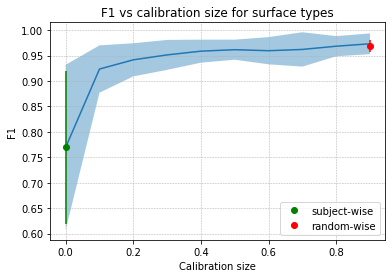

In [31]:
get_f1_calib(copy.deepcopy(label_f1), copy.deepcopy(sw_f1), copy.deepcopy(rw_f1), detail=False, model_id='ffn')

In [32]:
plt.rcParams['figure.figsize'] = [10, 10]

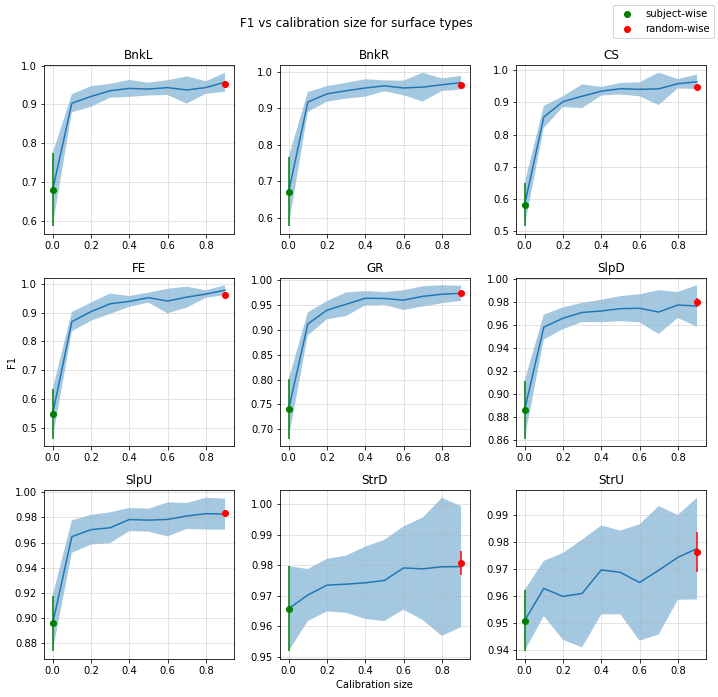

In [33]:
get_f1_calib(copy.deepcopy(label_f1), copy.deepcopy(sw_f1), copy.deepcopy(rw_f1), detail=True, model_id='ffn')